In [33]:
import os
import sys
import json
import pickle
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import string
import random 

import spacy

import numpy as np

import torch

import matplotlib.pyplot as plt

from SpeakQL.Allennlp_models.utils.spider import process_sql, evaluation
from SpeakQL.Allennlp_models.utils.misc_utils import Postprocess_rewrite_seq_freeze_POS, Postprocess_rewrite_seq_modify_POS


In [75]:
import importlib
from SpeakQL.Allennlp_models.utils import misc_utils
importlib.reload(misc_utils)
from SpeakQL.Allennlp_models.utils.misc_utils import \
    Postprocess_rewrite_seq_freeze_POS, Postprocess_rewrite_seq_modify_POS, EditDistance


In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
tables_json = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
kmaps = evaluation.build_foreign_key_map_from_json(tables_json)

### SQL eval funcs

In [3]:
def RebuildSQL(sql_str,
               db,
               db_dir='/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database/'):
    db_path = os.path.join(db_dir, db, db + ".sqlite")
    schema = process_sql.Schema(process_sql.get_schema(db_path))
    try:
        sql = process_sql.get_sql(schema, sql_str)
    except:
        print('{}\n{}\nprocess_sql.get_sql() failed'.format(sql_str, db))
        return None
    
    kmap = kmaps[db]
    valid_col_units = evaluation.build_valid_col_units(sql['from']['table_units'], schema)
    sql = evaluation.rebuild_sql_val(sql)
    sql = evaluation.rebuild_sql_col(valid_col_units, sql, kmap)
    
    return sql

In [4]:
def EvaluateSQL(pred_str,
                gold_str,
                db,
                db_dir='/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database/'):
    
    p_sql = RebuildSQL(pred_str, db, db_dir)
    g_sql = RebuildSQL(gold_str, db, db_dir)
    
    if (p_sql is None) or (g_sql is None):
        return 0, 0
    
    evaluator = evaluation.Evaluator()
    exact_match = evaluator.eval_exact_match(p_sql, g_sql)   # will modify p_sql, g_sql
    partials = evaluator.partial_scores
    partial_summary_score = sum([partials[tp]['f1'] * max(partials[tp]['label_total'], partials[tp]['pred_total']) for tp in partials]) / sum([max(partials[tp]['label_total'], partials[tp]['pred_total']) for tp in partials])

    return int(exact_match), partial_summary_score

In [5]:
pred_str = 'SELECT Pets.weight FROM Pets WHERE Pets.PetType = \'terminal\' ORDER BY Pets.pet_age Desc LIMIT 1'
gold_str = 'SELECT weight FROM pets ORDER BY pet_age LIMIT 1'
db = 'pets_1'
EvaluateSQL(pred_str, gold_str, db)

(0, 0.3)

In [6]:
def EvaluateSQL_full(glist,
                     plist,
                     db_id_list,
                     db_dir='/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database/'):
    # Only using 'match', not using 'exec'
    etype = 'match'
    
    # with open(gold) as f:
    #     glist = [l.strip().split('\t') for l in f.readlines() if len(l.strip()) > 0]

    # with open(predict) as f:
    #     plist = [l.strip().split('\t') for l in f.readlines() if len(l.strip()) > 0]
    
    # plist = [("select max(Share),min(Share) from performance where Type != 'terminal'", "orchestra")]
    # glist = [("SELECT max(SHARE) ,  min(SHARE) FROM performance WHERE TYPE != 'Live final'", "orchestra")]
    evaluator = evaluation.Evaluator()

    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    partial_types = ['select', 'select(no AGG)', 'where', 'where(no OP)', 'group(no Having)',
                     'group', 'order', 'and/or', 'IUEN', 'keywords']
    entries = []
    scores = {}

    for level in levels:
        scores[level] = {'count': 0, 'partial': {}, 'exact': 0., 'partial_summary': 0.}
        scores[level]['exec'] = 0
        for type_ in partial_types:
            scores[level]['partial'][type_] = {'acc': 0., 'rec': 0., 'f1': 0.,'acc_count':0,'rec_count':0}

    eval_err_num = 0
    for p, g, db in tqdm(zip(plist, glist, db_id_list), total=len(plist)):
        p_str = p
        g_str = g
        db_name = db
        db = os.path.join(db_dir, db, db + ".sqlite")
        schema = process_sql.Schema(process_sql.get_schema(db))
        g_sql = process_sql.get_sql(schema, g_str)
        hardness = evaluator.eval_hardness(g_sql)
        scores[hardness]['count'] += 1
        scores['all']['count'] += 1

        try:
            p_sql = process_sql.get_sql(schema, p_str)
        except:
            # If p_sql is not valid, then we will use an empty sql to evaluate with the correct sql
            p_sql = {
            "except": None,
            "from": {
                "conds": [],
                "table_units": []
            },
            "groupBy": [],
            "having": [],
            "intersect": None,
            "limit": None,
            "orderBy": [],
            "select": [
                False,
                []
            ],
            "union": None,
            "where": []
            }
            eval_err_num += 1
            print("eval_err_num:{}".format(eval_err_num))

        # rebuild sql for value evaluation
        kmap = kmaps[db_name]
        g_valid_col_units = evaluation.build_valid_col_units(g_sql['from']['table_units'], schema)
        g_sql = evaluation.rebuild_sql_val(g_sql)
        g_sql = evaluation.rebuild_sql_col(g_valid_col_units, g_sql, kmap)
        p_valid_col_units = evaluation.build_valid_col_units(p_sql['from']['table_units'], schema)
        p_sql = evaluation.rebuild_sql_val(p_sql)
        p_sql = evaluation.rebuild_sql_col(p_valid_col_units, p_sql, kmap)

#         if etype in ["all", "exec"]:
#             exec_score = evaluation.eval_exec_match(db, p_str, g_str, p_sql, g_sql)
#             if exec_score:
#                 scores[hardness]['exec'] += 1

        if etype in ["all", "match"]:
            exact_score = evaluator.eval_exact_match(p_sql, g_sql)
            partial_scores = evaluator.partial_scores
#             if exact_score == 0:
#                 print("{} pred: {}".format(hardness,p_str))
#                 print("{} gold: {}".format(hardness,g_str))
#                 print("")
            scores[hardness]['exact'] += exact_score
            scores['all']['exact'] += exact_score
            for type_ in partial_types:
                if partial_scores[type_]['pred_total'] > 0:
                    scores[hardness]['partial'][type_]['acc'] += partial_scores[type_]['acc']
                    scores[hardness]['partial'][type_]['acc_count'] += 1
                if partial_scores[type_]['label_total'] > 0:
                    scores[hardness]['partial'][type_]['rec'] += partial_scores[type_]['rec']
                    scores[hardness]['partial'][type_]['rec_count'] += 1
                scores[hardness]['partial'][type_]['f1'] += partial_scores[type_]['f1']
                if partial_scores[type_]['pred_total'] > 0:
                    scores['all']['partial'][type_]['acc'] += partial_scores[type_]['acc']
                    scores['all']['partial'][type_]['acc_count'] += 1
                if partial_scores[type_]['label_total'] > 0:
                    scores['all']['partial'][type_]['rec'] += partial_scores[type_]['rec']
                    scores['all']['partial'][type_]['rec_count'] += 1
                scores['all']['partial'][type_]['f1'] += partial_scores[type_]['f1']

            # Custom
            partial_summary_score = sum([partial_scores[tp]['f1'] * max(partial_scores[tp]['label_total'], partial_scores[tp]['pred_total']) for tp in partial_types]) / sum([max(partial_scores[tp]['label_total'], partial_scores[tp]['pred_total']) for tp in partial_types])
            scores[hardness]['partial_summary'] += partial_summary_score
            scores['all']['partial_summary'] += partial_summary_score
                
            entries.append({
                'predictSQL': p_str,
                'goldSQL': g_str,
                'hardness': hardness,
                'exact': exact_score,
                'partial': partial_scores
            })

    for level in levels:
        if scores[level]['count'] == 0:
            continue
        if etype in ["all", "exec"]:
            scores[level]['exec'] /= scores[level]['count']

        if etype in ["all", "match"]:
            scores[level]['exact'] /= scores[level]['count']
            scores[level]['partial_summary'] /= scores[level]['count']
            for type_ in partial_types:
                if scores[level]['partial'][type_]['acc_count'] == 0:
                    scores[level]['partial'][type_]['acc'] = 0
                else:
                    scores[level]['partial'][type_]['acc'] = scores[level]['partial'][type_]['acc'] / \
                                                             scores[level]['partial'][type_]['acc_count'] * 1.0
                if scores[level]['partial'][type_]['rec_count'] == 0:
                    scores[level]['partial'][type_]['rec'] = 0
                else:
                    scores[level]['partial'][type_]['rec'] = scores[level]['partial'][type_]['rec'] / \
                                                             scores[level]['partial'][type_]['rec_count'] * 1.0
                if scores[level]['partial'][type_]['acc'] == 0 and scores[level]['partial'][type_]['rec'] == 0:
                    scores[level]['partial'][type_]['f1'] = 1
                else:
                    scores[level]['partial'][type_]['f1'] = \
                        2.0 * scores[level]['partial'][type_]['acc'] * scores[level]['partial'][type_]['rec'] / (
                        scores[level]['partial'][type_]['rec'] + scores[level]['partial'][type_]['acc'])

    evaluation.print_scores(scores, etype)
    print('================   PARTIAL MATCHING SUMMARY SCORE    ================')
    this_scores = [scores[level]['partial_summary'] for level in levels]
    print("{:20} {:<20.3f} {:<20.3f} {:<20.3f} {:<20.3f} {:<20.3f}".format("partial_summary", *this_scores))
    print()
    print('\t'.join([str(scores[level]['exact']) for level in levels]))
    print('\t'.join([str(scores[level]['partial_summary']) for level in levels]))
    # return scores



### Model aggregation - Agreement based (SQL)

In [136]:
output_save_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs/ratsql-test-save/'
reranker_output_path = os.path.join(output_save_dir, 'humantest-yshao-1.10.0.0.json')
rewriter_taggerILM_output_path = os.path.join(output_save_dir, 'humantest-yshao-2.5.0.0t-2.4.0.0i.json')
rewriter_s2s_output_path = os.path.join(output_save_dir, 'humantest-yshao-3.6.0.1.json')


In [137]:
with open(reranker_output_path, 'r') as f:
    reranker_outputs = json.load(f)
with open(rewriter_taggerILM_output_path, 'r') as f:
    rewriter_taggerILM_outputs = json.load(f)
with open(rewriter_s2s_output_path, 'r') as f:
    rewriter_s2s_outputs = json.load(f)

len(reranker_outputs), len(rewriter_taggerILM_outputs), len(rewriter_s2s_outputs)

(100, 100, 100)

In [138]:
print(reranker_outputs[0][0].keys())
print(rewriter_taggerILM_outputs[0][0].keys())
print(rewriter_s2s_outputs[0][0].keys())

dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'original_id', 'span_ranges', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'is_reranker_selection'])
dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'original_id', 'span_ranges', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'alignment_span_pairs', 'alignment_text_pairs', 'rewriter_tags', 'rewriter_edits', 'pred_tags', 'pred_ILM', 'pred_ILM_cands', 'rewritten_question', 'pred_sql', 'score', 'exact'])
dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'original_id', 'span_ranges', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'align

In [139]:
reranker_selected_outputs = [c for d in reranker_outputs for c in d if c['is_reranker_selection']]
rewriter_taggerILM_selected_outputs = [d[0] for d in rewriter_taggerILM_outputs]
rewriter_s2s_selected_outputs = [d[0] for d in rewriter_s2s_outputs]


In [140]:
reranker_output_sqls = [c['pred_sql'] for c in reranker_selected_outputs]
rewriter_taggerILM_output_sqls = [c['pred_sql'] for c in rewriter_taggerILM_selected_outputs]
rewriter_s2s_output_sqls = [c['pred_sql'] for c in rewriter_s2s_selected_outputs]
gold_sqls = [c['query'] for c in reranker_selected_outputs]

len(reranker_output_sqls), len(rewriter_taggerILM_output_sqls), len(rewriter_s2s_output_sqls), len(gold_sqls)

(100, 100, 100, 100)

In [141]:
for i in range(0, len(gold_sqls), 60):
    p1 = reranker_output_sqls[i]
    p2 = rewriter_taggerILM_output_sqls[i]
    p3 = rewriter_s2s_output_sqls[i]
    g = gold_sqls[i]
    
    sc1 = reranker_selected_outputs[i]['score']
    sc2 = rewriter_taggerILM_selected_outputs[i]['score']
    sc3 = rewriter_s2s_selected_outputs[i]['score']
    
    ex1 = reranker_selected_outputs[i]['exact']
    ex2 = rewriter_taggerILM_selected_outputs[i]['exact']
    ex3 = rewriter_s2s_selected_outputs[i]['exact']
    
    print(p1, f'({sc1:.4f}, {bool(ex1)})')
    print(p2, f'({sc2:.4f}, {bool(ex2)})')
    print(p3, f'({sc3:.4f}, {bool(ex3)})')
    print()
    print(g)
    print('-'*50)

SELECT Count(*) FROM Pets WHERE Pets.weight > 'terminal' (1.0000, True)
SELECT Count(*) FROM Pets WHERE Pets.weight > 'terminal' (1.0000, True)
SELECT Count(*) FROM Pets WHERE Pets.weight > 'terminal' (1.0000, True)

SELECT count(*) FROM pets WHERE weight  >  10
--------------------------------------------------
SELECT Count(*) FROM VOTES WHERE VOTES.state = 'terminal' (0.2222, False)
SELECT Count(*) FROM VOTES WHERE VOTES.state = 'terminal' OR VOTES.state = 'terminal' (1.0000, True)
SELECT Count(*) FROM AREA_CODE_STATE JOIN VOTES ON AREA_CODE_STATE.state = VOTES.state WHERE AREA_CODE_STATE.state = 'terminal' OR AREA_CODE_STATE.state = 'terminal' (1.0000, False)

SELECT count(*) FROM votes WHERE state  =  'NY' OR state  =  'CA'
--------------------------------------------------


In [142]:
model_matches = [0 for _ in range(3)]

major_counter = Counter()  # [x]: How many samples have x models agree?

major_output_sqls = []  # Save the vote results (str of sql)

fallback_id = 1   # When no agreement, fallback to taggerILM 

for i in tqdm(range(len(gold_sqls))):
    p0 = reranker_output_sqls[i]
    p1 = rewriter_taggerILM_output_sqls[i]
    p2 = rewriter_s2s_output_sqls[i]
    
    db = reranker_selected_outputs[i]['db_id']
    db1 = rewriter_taggerILM_selected_outputs[i]['db_id']
    db2 = rewriter_s2s_selected_outputs[i]['db_id']
    assert db == db1 == db2
    
    _p_str_list = [p0, p1, p2]
    _p_sql_list = [RebuildSQL(p_str, db) for p_str in _p_str_list]
    _p_dumps_list = [json.dumps(p_sql, sort_keys=True) for p_sql in _p_sql_list]
    
    # Majority voting, with a Counter 
    _dumps_counter = Counter(_p_dumps_list)
    _maj_dumps, _maj_cnt = _dumps_counter.most_common(1)[0]
    if _maj_cnt == 1:
        # All diff 
        _out_dumps = _p_dumps_list[fallback_id]
    else:
        # Has majority 
        _out_dumps = _maj_dumps
    
    # Save results 
    major_counter[_maj_cnt] += 1
    
    _out_id = None
    for j, _dumps in enumerate(_p_dumps_list):
        if _dumps == _out_dumps:
            model_matches[j] += 1
            _out_id = j
    
    major_output_sqls.append(_p_str_list[_out_id])
    
#     if p1_sql == p2_sql:
#         if p1_sql == p3_sql:
#             # 1 == 2 == 3
#             cnt_all_match += 1
#             _out_id = 1
#         else:
#             # 1 == 2 != 3
#             cnt_2v1 += 1
#             _out_id = 1
#     elif p1_sql == p3_sql:
#         # 1 == 3 != 2
#         cnt_2v1 += 1
#         _out_id = 1
#     elif p2_sql == p3_sql:
#         # 2 == 3 != 1
#         cnt_2v1 += 1
#         _out_id = 2
#     else:
#         # 1 != 2 != 3 != 1
#         cnt_fallbacks += 1
#         _out_id = 2  # Fallback to taggerILM since it's the best performing one 
    
#     major_output_sqls.append(_out)

In [143]:
model_matches, major_counter

([65, 95, 68], Counter({3: 51, 1: 23, 2: 26}))

In [144]:
EvaluateSQL_full(plist=major_output_sqls,
                 glist=gold_sqls,
                 db_id_list=[c['db_id'] for c in reranker_selected_outputs])


                     easy                 medium               hard                 extra                all                 
count                22                   52                   19                   7                    100                 

====================== EXACT MATCHING ACCURACY =====================
exact match          0.636                0.365                0.211                0.143                0.380               

---------------------PARTIAL MATCHING ACCURACY----------------------
select               0.955                0.692                0.789                1.000                0.790               
select(no AGG)       0.955                0.692                0.789                1.000                0.790               
where                0.375                0.520                0.500                0.167                0.451               
where(no OP)         0.375                0.560                0.583                0.333              

### Samples

#### Loading samples

In [158]:
VERSION = '2.12.1.1t-2.31.0.1i'

output_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs'

model_output_path = os.path.join(output_dir, 'ratsql-test-save', f'{VERSION}.json')
# compare_output_path = os.path.join(output_dir, 'ratsql-asr-test-save', 'First-cands.json')


In [159]:
with open(model_output_path, 'r') as f:
    model_outputs = json.load(f)

len(model_outputs), model_outputs[0][0].keys()

(547,
 dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'span_ranges', 'original_id', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'alignment_span_pairs', 'alignment_text_pairs', 'rewriter_tags', 'rewriter_edits', 'pred_tags', 'pred_ILM', 'pred_ILM_cands', 'rewritten_question', 'pred_sql', 'score', 'exact', 'exec']))

In [160]:
output_cands = [d_m[0] for d_m in model_outputs]

#### Random samples with any edits

In [161]:
output_cands_with_edits = [c for c in output_cands if len(c['rewriter_edits']) > 0]
for c in random.sample(output_cands_with_edits, k=20):
    print('ASR Question:', c['question'])
    print('Rwt Question:', c['rewritten_question'])
    print('Gold Question:', c['gold_question'])
    print()

ASR Question: how many languages are spoken in Aruba.
Rwt Question: how many languages are spoken in Aruba ?
Gold Question: How many languages are spoken in Aruba?

ASR Question: find the average age of students who do not have any pets.
Rwt Question: find the average age of students who do not have any pets .
Gold Question: Find the average age of students who do not have any pet.

ASR Question: What is the agent? Hometown of every teacher?
Rwt Question: What is the age Hometown of every teacher ?
Gold Question: What is the age and hometown of every teacher?

ASR Question: What is the abbreviation of the airline Has the fewest flights in what country is it in?
Rwt Question: What is the abbreviation of the airline Has the fewest flights in what country is it in ?
Gold Question: What is the abbreviation of the airilne has the fewest flights and what country is it in?

ASR Question: what are the IDs? Version numbers and type codes for each template.
Rwt Question: what are the IDs , Versi

#### Samples with more edits

In [162]:
for c_m in sorted(output_cands, key=lambda c : len(c['rewriter_edits']), reverse=True)[:20]:
    print('ASR Question:', c_m['question'])
#     print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
    print('Rwt Question:', c_m['rewritten_question'])
#     print('Compare SQL:', c_c['pred_sql'], f"({c_c['score']})")
#     print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m['score']})")
    print('Gold Question:', c_m['gold_question'])
#     print('Gold SQL:', c_m['query'])
    print()

ASR Question: What is the document? I d 10 put idea and description for document named Robin CV.
Rwt Question: What is the document id 10 type type with and description for document named Robin id b ''
Gold Question: What is the document id, template id and description for document named "Robbin CV"?

ASR Question: What are the odds of documents that contained the paragraph Text Brazil and Ireland.
Rwt Question: What are the ids of documents that contain the paragraph Text Brazil and Ireland ?
Gold Question: What are the ids of documents that contain the paragraph text 'Brazil' and 'Ireland'?

ASR Question: what are the odds and texts of paragraphs in the document titled Welcome to N. Y.
Rwt Question: what are the ids and texts of paragraphs in the document titled `` welcome cv to '' ?
Gold Question: What are the ids and texts of paragraphs in the document titled 'Welcome to NY'?

ASR Question: find the idea in weight of all pets whose ages older than one.
Rwt Question: find the id and

In [43]:
# output_cand_subset = [c for c in output_cands if c['db_id'] == 'concert_singer']

# for c_m in sorted(output_cand_subset, key=lambda c : len(c['rewriter_edits']), reverse=True):
#     print('ASR Question:', c_m['question'])
# #     print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
#     print('Rwt Question:', c_m['rewritten_question'])
# #     print('Compare SQL:', c_c['pred_sql'], f"({c_c['score']})")
# #     print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m['score']})")
#     print('Gold Question:', c_m['gold_question'])
# #     print('Gold SQL:', c_m['query'])
#     print()

#### Samples with/without improvements

In [165]:
VERSION = '2.12.1.1t-2.31.0.1i'

output_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs'

model_output_path = os.path.join(output_dir, 'uskg-large-test-save', f'{VERSION}.json')
# model_output_path = os.path.join(output_dir, 'uskg-test-save', 'First-cands.json')
compare_output_path = os.path.join(output_dir, 'uskg-large-test-save', 'First-cands.json')


In [166]:
with open(model_output_path, 'r') as f:
    model_outputs = json.load(f)
with open(compare_output_path, 'r') as f:
    compare_outputs = json.load(f)
    
len(model_outputs), len(compare_outputs), model_outputs[0][0].keys(), compare_outputs[0][0].keys()

(547,
 547,
 dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'span_ranges', 'original_id', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'alignment_span_pairs', 'alignment_text_pairs', 'rewriter_tags', 'rewriter_edits', 'token_phonemes', 'token_phoneme_spans', 'predicted_rewriter_tags', 'align_tags', 'asr_question', 'asr_question_toks', 'rewritten_question', 'pred_sql', 'score', 'exact', 'exec']),
 dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'span_ranges', 'original_id', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'alignment_span_pairs', 'alignment_text_pairs', 'rewriter_tags', 'rewriter_edits', 'pred_sql', 'score', 'exact', 'exec']))

In [ ]:
## Large improvements against raw rat-sql

output_cands = [d_m[0] for d_m in model_outputs]

for c_m in sorted(output_cands, key=lambda c : (c['score'] - c['ratsql_pred_score']), reverse=True)[:20]:
    print('ASR Question:', c_m['question'])
    print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
    print('Rwt Question:', c_m['rewritten_question'])
    # print('Compare SQL:', c_c['pred_sql'], f"({c_c['score']})")
    print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m['score']})")
    print('Gold Question:', c_m['gold_question'])
    print('Gold SQL:', c_m['query'])
    print()

In [178]:
## Large improvements on uskg

output_cand_pairs = [(d_m[0], d_c[0]) for d_m, d_c in zip(model_outputs, compare_outputs)]

_score_key = 'exec'

for c_m, c_c in sorted(output_cand_pairs, key=lambda c : (c[0][_score_key] - c[1][_score_key]), reverse=True)[:20]:
    print('ASR Question:', c_m['asr_question'])
    # print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
    print('Rwt Question:', c_m['rewritten_question'])
    print('Compare SQL:', c_c['pred_sql'], f"({c_c[_score_key]})")
    print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m[_score_key]})")
    print('Gold Question:', c_m['gold_question'])
    print('Gold SQL:', c_m['query'])
    print()


ASR Question: How much does the youngest doc way?
Rwt Question: How much does the youngest pet cat?
Compare SQL: select sum(age) from student where age = (select min(age) from student where stuid = t2.stuid order by age asc limit 1) (0)
Rwt Question SQL: select weight from pets order by pet_age asc limit 1 (1)
Gold Question: How much does the youngest dog weigh?
Gold SQL: SELECT weight FROM pets ORDER BY pet_age LIMIT 1

ASR Question: find the idea in weight of all pets whose ages older than one.
Rwt Question: find the id and weight of all pets whose age is older than 1.
Compare SQL: select avg(weight) from pets where pet_age > 1 (0)
Rwt Question SQL: select petid, weight from pets where pet_age > 1 (1)
Gold Question: Find the id and weight of all pets whose age is older than 1.
Gold SQL: SELECT petid ,  weight FROM pets WHERE pet_age  >  1

ASR Question: What is the idea? In weight of every pet who is older than one.
Rwt Question: What is the id and weight of every pet who is older th

In [182]:
## Large improvements on uskg (exec + exact)

output_cand_pairs = [(d_m[0], d_c[0]) for d_m, d_c in zip(model_outputs, compare_outputs)]

_comp_key = lambda c : (c[0]['exec'] - c[1]['exec']) + (c[0]['exact'] - c[1]['exact'])

for c_m, c_c in sorted(output_cand_pairs, key=_comp_key, reverse=True)[:50]:
    print(c_m['db_id'])
    print('ASR Question:', c_m['asr_question'])
    # print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
    print('Rwt Question:', c_m['rewritten_question'])
    print('Compare SQL:', c_c['pred_sql'], f"({c_c['exec'] * c_c['exact']})")
    print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m['exec'] * c_m['exact']})")
    print('Gold Question:', c_m['gold_question'])
    print('Gold SQL:', c_m['query'])
    print()


pets_1
ASR Question: How much does the youngest doc way?
Rwt Question: How much does the youngest pet cat?
Compare SQL: select sum(age) from student where age = (select min(age) from student where stuid = t2.stuid order by age asc limit 1) (0)
Rwt Question SQL: select weight from pets order by pet_age asc limit 1 (1)
Gold Question: How much does the youngest dog weigh?
Gold SQL: SELECT weight FROM pets ORDER BY pet_age LIMIT 1

pets_1
ASR Question: find the idea in weight of all pets whose ages older than one.
Rwt Question: find the id and weight of all pets whose age is older than 1.
Compare SQL: select avg(weight) from pets where pet_age > 1 (0)
Rwt Question SQL: select petid, weight from pets where pet_age > 1 (1)
Gold Question: Find the id and weight of all pets whose age is older than 1.
Gold SQL: SELECT petid ,  weight FROM pets WHERE pet_age  >  1

pets_1
ASR Question: What is the idea? In weight of every pet who is older than one.
Rwt Question: What is the id and weight of ever

In [177]:
## Large drops from uskg (uskg-mixed)

output_cand_pairs = [(d_m[0], d_c[0]) for d_m, d_c in zip(model_outputs, compare_outputs)]

for c_m, c_c in sorted(output_cand_pairs, key=lambda c : (c[1]['exec'] - c[0]['exec']), reverse=True)[:30]:
    print('ASR Question:', c_m['asr_question'])
    # print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
    print('Rwt Question:', c_m['rewritten_question'])
    print('Compare SQL:', c_c['pred_sql'], f"({c_c['score']})")
    print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m['score']})")
    print('Gold Question:', c_m['gold_question'])
    print('Gold SQL:', c_m['query'])
    print()


ASR Question: how many pets are owned by students that have an H greater than 20.
Rwt Question: how many pets are owned by students that have an age greater than 20?
Compare SQL: select count(*) from has_pet as t1 join pets as t2 on t1.petid = t2.petid join student as t3 on t3.stuid = t1.petid where t3.age > 20 (1.0)
Rwt Question SQL: select count(distinct t2.petid) from has_pet as t1 join pets as t2 on t1.petid = t2.petid join student as t3 on t1.stuid = t3.stuid where t3.age > 20 (0.6666666666666666)
Gold Question: How many pets are owned by students that have an age greater than 20?
Gold SQL: SELECT count(*) FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid WHERE T1.age  >  20

ASR Question: find the number of dog pets that are raised by female students with sex F.
Rwt Question: find the number of weight pets that are raised by female students with sex F.
Compare SQL: select count(*) from pets as t1 join has_pet as t2 on t1.petid = t2.petid join student as t3 on t2.stui

In [ ]:
# ## Large improvements against rat-sql-asr
# ## In fact, a lot of these are where rat-sql-asr worse than rat-sql, no rewriting involved 

# output_cand_pairs = [(d_m[0], d_c[0]) for d_m, d_c in zip(model_outputs, compare_outputs)]

# for c_m, c_c in sorted(output_cand_pairs, key=lambda c : (c[0]['score'] - c[1]['score']), reverse=True)[:20]:
#     print('ASR Question:', c_m['question'])
#     # print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
#     print('Rwt Question:', c_m['rewritten_question'])
#     print('Compare SQL:', c_c['pred_sql'], f"({c_c['score']})")
#     print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m['score']})")
#     print('Gold Question:', c_m['gold_question'])
#     print('Gold SQL:', c_m['query'])
#     print()


In [171]:
## POS fixing samples 
target_pos = 'PROPN'

pos_fixing_cands = []
for c_m in tqdm(output_cands):
    _orig_doc = nlp(c_m['asr_question'])
    _orig_pos_toks = [str(t) for t in _orig_doc if t.pos_ == target_pos and str(t).lower() != 'i']
    _rwt_doc = nlp(c_m['rewritten_question'])
    _rwt_pos_toks = [str(t) for t in _rwt_doc if t.pos_ == target_pos and str(t).lower() != 'i']

    if _orig_pos_toks != _rwt_pos_toks:
        pos_fixing_cands.append(c_m)


(93,
 'how many weight pets are raised by female students?',
 'how many weight pets are raised by female students?')

In [172]:
len(pos_fixing_cands), pos_fixing_cands[0]['asr_question'], pos_fixing_cands[0]['rewritten_question']

(93,
 'how many Doug pets are raised by female students.',
 'how many weight pets are raised by female students?')

In [174]:
## Large improvements against rat-sql

for c_m in sorted(pos_fixing_cands, key=lambda c : (c['score'] - c['ratsql_pred_score']), reverse=True)[:40]:
    print('ASR Question:', c_m['asr_question'])
    print('ASR Question SQL:', c_m['ratsql_pred_sql'], f"({c_m['ratsql_pred_score']})")
    print('Rwt Question:', c_m['rewritten_question'])
    # print('Compare SQL:', c_c['pred_sql'], f"({c_c['score']})")
    print('Rwt Question SQL:', c_m['pred_sql'], f"({c_m['score']})")
    print('Gold Question:', c_m['gold_question'])
    print('Gold SQL:', c_m['query'])
    print()

ASR Question: show. It's for all templates not used by any document.
ASR Question SQL: SELECT Templates.Template_Details FROM Templates WHERE Templates.Template_ID NOT IN (SELECT Documents.Template_ID FROM Documents) (0.1111111111111111)
Rwt Question: show ids for all templates not used by any document.
Rwt Question SQL: select template_id from templates except select template_id from documents (1.0)
Gold Question: Show ids for all templates not used by any document.
Gold SQL: SELECT template_id FROM Templates EXCEPT SELECT template_id FROM Documents

ASR Question: what are the? It's for templates that are not used in any documents.
ASR Question SQL: SELECT Templates.Template_Details FROM Templates WHERE Templates.Template_ID NOT IN (SELECT Documents.Template_ID FROM Documents) (0.1111111111111111)
Rwt Question: what are the ids for templates that are not used in any documents?
Rwt Question SQL: select template_id from templates except select template_id from documents (1.0)
Gold Quest

### POS analysis

In [188]:
POS_LIST = ["PUNCT", "NUM", "VERB", "PRON", "ADP", "NOUN", "AUX", "DET",
    "SCONJ", "PART", "ADJ", "CCONJ", "ADV", "PROPN"]

POS2idx = defaultdict(lambda: 999)
for i, _pos in enumerate(POS_LIST):
    POS2idx[_pos] = i

In [205]:
def Sentence_toks_POS_tagging(tokens):
    '''
    Get the POS tags for tokens given in Spider
    (the tokenization doesn't always align with Spacy, so need some hard-coded patches)
    '''
    
    _question_str = ' '.join(tokens)
    _question_doc = nlp(_question_str)
    
    _question_pos = []
    _di = 0     # index to _question_doc 
    
    ## Patches for Spacy and original tokenization mismatches
    for i, tok in enumerate(question_toks):
        if tok == "id's":
            # will become "i", "d", "'s"
            assert str(_question_doc[_di:_di + 3]) == tok, \
                (' '.join([str(t) for t in _question_doc]), _question_str)
            _question_pos.append(_question_doc[_di + 1].pos_)   # [_di+1] is "d", is NOUN, the closest
            _di += 3
        elif tok == "id":
            # will become "i", "d"
            assert str(_question_doc[_di:_di + 2]) == tok, \
                (' '.join([str(t) for t in _question_doc]), _question_str)
            _question_pos.append(_question_doc[_di + 1].pos_)   # [_di+1] is "d", is NOUN, the closest
            _di += 2
        elif "'" in tok[1:-1]:
            # "'" in middle, *sometimes* will be splitted into 2
            if str(_question_doc[_di:_di + 2]) == tok:
                # splitted
                _question_pos.append(_question_doc[_di].pos_)       # use the 1st one
                _di += 2
            elif str(_question_doc[_di]) == tok:
                # not splitted
                _question_pos.append(_question_doc[_di].pos_)
                _di += 1
        else:
            # no mismatch
            _question_pos.append(_question_doc[_di].pos_)
            _di += 1
    
    return _question_pos

In [74]:
## Edit distance function, (distance between transcription and gold text) can be used as supervision signal 

## Moved to misc_utils

# def EditDistance(S, T, matching_type=False):
#     # [i, j]: min edit distance of S[:i] vs. T[:j] 
#     min_edit_dist = np.zeros((len(S) + 1, len(T) + 1), dtype=int)

#     # for state [i, j], 0 = match, 1 = ignore S, 2 = ignore T, 3 = ignore both  
#     backtrack = np.zeros((len(S) + 1, len(T) + 1), dtype=int)

#     min_edit_dist[:, 0] = np.arange(len(S) + 1, dtype=int)
#     min_edit_dist[0, :] = np.arange(len(T) + 1, dtype=int)
#     backtrack[1:, 0] = 1
#     backtrack[0, 1:] = 2

#     for i in range(1, len(S) + 1):
#         for j in range(1, len(T) + 1):
#             if S[i-1].lower() == T[j-1].lower():
#                 min_edit_dist[i, j] = min_edit_dist[i-1, j-1]
#                 backtrack[i, j] = 0
#             else:
#                 choices = [min_edit_dist[i-1, j], min_edit_dist[i, j-1]]
#                 if ((S[i-1] in string.punctuation) == (T[j-1] in string.punctuation)) or (not matching_type):
#                     # both are punct, or both are words; can substitute 
#                     # if not matching_type, everything can substitute 
#                     choices.append(min_edit_dist[i-1, j-1])
#                 min_edit_dist[i, j] = min(*choices) + 1
#                 backtrack[i, j] = np.argmin(choices) + 1
                
#     curr_state = (len(S), len(T))
#     pairs = []
#     while curr_state != (0, 0):
#         i, j = curr_state
#         action = backtrack[i, j]
#         if action == 0:
#             pairs.append((S[i-1], T[j-1]))
#             curr_state = (i-1, j-1)
#         elif action == 1:
#             pairs.append((S[i-1], ''))
#             curr_state = (i-1, j)
#         elif action == 2:
#             pairs.append(('', T[j-1]))
#             curr_state = (i, j-1)
#         else:
#             pairs.append((S[i-1], T[j-1]))
#             curr_state = (i-1, j-1)
#     pairs.reverse()
    
#     return min_edit_dist[len(S), len(T)], pairs


In [281]:
VERSION = '2.12.1.2t-2.18.2.2i'

output_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs'

model_output_path = os.path.join(output_dir, 'ratsql-test-save', f'{VERSION}.json')

In [282]:
with open(model_output_path, 'r') as f:
    model_outputs = json.load(f)

len(model_outputs)

547

In [283]:
model_outputs[0][0].keys()

dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'span_ranges', 'original_id', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'alignment_span_pairs', 'alignment_text_pairs', 'rewriter_tags', 'rewriter_edits', 'pred_tags', 'pred_ILM', 'pred_ILM_cands', 'rewritten_question', 'pred_sql', 'score', 'exact', 'exec'])

In [284]:
d = model_outputs[116]
c = d[0]
c['alignment_text_pairs'], c['rewriter_tags'], c['rewriter_edits'], list(filter(lambda x : x != 'O', c['pred_tags'])), c['pred_ILM']

([['Twitter', 'What are'],
  ['flight', 'flight'],
  ['numbers', 'numbers'],
  ['of', 'of'],
  ['flights', 'flights'],
  ['arriving', 'arriving'],
  ['at', 'at'],
  ['city', 'City'],
  ['Aberdeen', "`` Aberdeen ''"],
  ['.', '?']],
 ['U-EDIT',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'U-EDIT',
  'U-EDIT'],
 [{'src_span': [0],
   'tgt_span': [0, 1],
   'src_text': 'Twitter',
   'tgt_text': 'What are'},
  {'src_span': [8],
   'tgt_span': [9, 10, 11],
   'src_text': 'Aberdeen',
   'tgt_text': "`` Aberdeen ''"},
  {'src_span': [9], 'tgt_span': [12], 'src_text': '.', 'tgt_text': '?'}],
 ['U-EDIT',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP',
  'O-KEEP'],
 ['What', 'are', '[ANS]', '@end@'])

In [285]:
doc = nlp(c['gold_question'])

for token in doc:
    print(f'{token.text:<16s}{token.lemma_:<16s}{token.pos_:<6s}{token.tag_:<6s}{token.shape_:<10s}{str(token.is_alpha):<6s}{str(token.is_stop):<6s}')
print()
for ent in doc.ents:
    print(f'{ent.text:<20s}{ent.start_char:<6d}{ent.end_char:<6d}{ent.label_}')

What            what            PRON  WP    Xxxx      True  True  
are             be              AUX   VBP   xxx       True  True  
flight          flight          NOUN  NN    xxxx      True  False 
numbers         number          NOUN  NNS   xxxx      True  False 
of              of              ADP   IN    xx        True  True  
flights         flight          NOUN  NNS   xxxx      True  False 
arriving        arrive          VERB  VBG   xxxx      True  False 
at              at              ADP   IN    xx        True  True  
City            City            PROPN NNP   Xxxx      True  False 
"               "               PUNCT ``    "         False False 
Aberdeen        Aberdeen        PROPN NNP   Xxxxx     True  False 
"               "               PUNCT ''    "         False False 
?               ?               PUNCT .     ?         False False 

City                47    51    GPE


In [286]:
doc = nlp(c['question'])

for token in doc:
    print(f'{token.text:<16s}{token.lemma_:<16s}{token.pos_:<6s}{token.tag_:<6s}{token.shape_:<10s}{str(token.is_alpha):<6s}{str(token.is_stop):<6s}')
print()
for ent in doc.ents:
    print(f'{ent.text:<20s}{ent.start_char:<6d}{ent.end_char:<6d}{ent.label_}')

Twitter         twitter         NOUN  NN    Xxxxx     True  False 
flight          flight          NOUN  NN    xxxx      True  False 
numbers         number          NOUN  NNS   xxxx      True  False 
of              of              ADP   IN    xx        True  True  
flights         flight          NOUN  NNS   xxxx      True  False 
arriving        arrive          VERB  VBG   xxxx      True  False 
at              at              ADP   IN    xx        True  True  
city            city            NOUN  NN    xxxx      True  False 
Aberdeen        Aberdeen        PROPN NNP   Xxxxx     True  False 
.               .               PUNCT .     .         False False 



In [ ]:
# EditDistance(c['rewritten_question'].split(' '), c['gold_question_toks'])

In [ ]:
# for d in model_outputs[:50]:
#     c = d[0]
#     gold_question_nlp = nlp(c['gold_question'])
#     if len(gold_question_nlp) != len(c['gold_question_toks']):
#         print([str(tok) for tok in gold_question_nlp])
#         print(c['gold_question_toks'])
#         _, _matches = EditDistance([str(tok) for tok in gold_question_nlp], c['gold_question_toks'], matching_type=True)
#         print(_matches)
#         print()

In [ ]:
# for d in model_outputs[::100]:
#     c = d[0]
#     gold_question_nlp = nlp(c['gold_question'])
# #     if len(gold_question_nlp) != len(c['gold_question_toks']):
# #         print([str(tok) for tok in gold_question_nlp])
# #         print(c['gold_question_toks'])

#     print([str(tok) for tok in gold_question_nlp])
#     print(c['question_toks'])
    
#     _, _matches = EditDistance([str(tok) for tok in gold_question_nlp], c['question_toks'], matching_type=True)
#     print(_matches)
#     print()
    

#### Error stats on different POS

In [ ]:
# # Dict[str: pos, Dict[str: ('corr', 'incorr', 'acc', etc.), int/float]]
# stats_per_pos = defaultdict(lambda: defaultdict(int))
# # Dict[str: pos, Dict[str: token, Counter[str: pred_token, int]]]
# tokens_per_pos = defaultdict(lambda: defaultdict(Counter))

# for d in tqdm(model_outputs):
#     c = d[0]
#     gold_question_nlp = nlp(c['gold_question'])
# #     rewritten_question_nlp = nlp(c['question'])  # ASR, no fix
#     rewritten_question_nlp = nlp(c['rewritten_question'])
    
#     gold_question_nlp_tokens = [str(tok) for tok in gold_question_nlp]
#     rewritten_question_nlp_tokens = [str(tok) for tok in rewritten_question_nlp]

#     _, _matches = EditDistance(gold_question_nlp_tokens, rewritten_question_nlp_tokens, matching_type=True)
#     _is_matched_list = []
#     _src_matches = []
#     for _s, _t in _matches:
#         if len(_s) == 0:
#             # source empty token 
#             continue
#         _m = (_s.lower() == _t.lower())
#         _is_matched_list.append(_m)
        
#         _src_matches.append((_s.lower(), _t.lower()))
        
#     assert len(_is_matched_list) == len(_src_matches) == len(gold_question_nlp), \
#         f'{_is_matched_list}\n{_src_matches}\n{gold_question_nlp}'
    
#     for _tok, _m, (_s, _t) in zip(gold_question_nlp, _is_matched_list, _src_matches):
#         _pos = _tok.pos_
#         if _m:
#             stats_per_pos[_pos]['corr'] += 1
#         else:
#             stats_per_pos[_pos]['incorr'] += 1
        
#         tokens_per_pos[_pos][_s][_t] += 1

#     # inspect 
#     if c['original_id'] % 100 == 0:
#         print(_matches)
#         print(_src_matches)
#         print(_is_matched_list)
            
# stats_per_pos.keys()
    

In [298]:
IGNORE_I_D = False  # ignore source token it's, i d, etc. that correspond to id 

# Dict[str: pos, Dict[str: ('corr', 'incorr', 'acc', etc.), int/float]]
stats_per_pos = defaultdict(lambda: defaultdict(int))  # key POS: gold, compared to rewritten 
stats_per_pos_ASR_raw = defaultdict(lambda: defaultdict(int))  # key POS: question (raw), compared to gold 
stats_per_pos_ASR = defaultdict(lambda: defaultdict(int))  # key POS: question (raw), rewritten compared to gold 
# Dict[str: pos, Dict[str: token, Counter[str: pred_token, int]]]
tokens_per_pos = defaultdict(lambda: defaultdict(Counter))

for d in tqdm(model_outputs):
    c = d[0]
    gold_question_nlp = nlp(c['gold_question'])
    question_nlp = nlp(c['question'])  # ASR, no fix
    rewritten_question_nlp = nlp(c['rewritten_question'])
    
    gold_question_nlp_tokens = [str(tok).lower() for tok in gold_question_nlp]
    question_nlp_tokens = [str(tok).lower() for tok in question_nlp]
    rewritten_question_nlp_tokens = [str(tok).lower() for tok in rewritten_question_nlp]

    _, _matches = EditDistance(gold_question_nlp_tokens, rewritten_question_nlp_tokens, matching_type=True)
    _g2r = dict()
    _r2g = dict()
    _gid = _rid = 0
    for _g, _r in _matches:
        if len(_g) == 0:
            # _g empty, _r not empty 
            _r2g[_rid] = -1
            _rid += 1
        elif len(_r) == 0:
            # _r empty, _g not empty 
            _g2r[_gid] = -1
            _gid += 1
        else:
            _r2g[_rid] = _gid
            _g2r[_gid] = _rid
            _gid += 1
            _rid += 1

    _, _matches = EditDistance(question_nlp_tokens, rewritten_question_nlp_tokens, matching_type=True)
    _q2r = dict()
    _r2q = dict()
    _qid = _rid = 0
    for _q, _r in _matches:
        if len(_q) == 0:
            # _q empty, _r not empty 
            _r2q[_rid] = -1
            _rid += 1
        elif len(_r) == 0:
            # _r empty, _q not empty 
            _q2r[_qid] = -1
            _qid += 1
        else:
            _r2q[_rid] = _qid
            _q2r[_qid] = _rid
            _qid += 1
            _rid += 1
    
#     assert len(_is_matched_list) == len(_src_matches) == len(gold_question_nlp), \
#         f'{_is_matched_list}\n{_src_matches}\n{gold_question_nlp}'

    for _gid, _g_str in enumerate(gold_question_nlp_tokens):
        _pos = gold_question_nlp[_gid].pos_
        
        _rid = _g2r[_gid]
        if _rid == -1:
            # aligned to empty 
            stats_per_pos[_pos]['incorr'] += 1
            continue
        # aligned to token 
        _r_str = rewritten_question_nlp_tokens[_rid]
        tokens_per_pos[_pos][_g_str][_r_str] += 1
        if _r_str == _g_str:
            stats_per_pos[_pos]['corr'] += 1
        else:
            stats_per_pos[_pos]['incorr'] += 1
        
    for _qid, _q_str in enumerate(question_nlp_tokens):
        if IGNORE_I_D and _q_str.lower() in ["it's", "i", "d"]:
            continue
            
        _pos = question_nlp[_qid].pos_
        
        _rid = _q2r[_qid]
        if _rid == -1:
            # aligned to empty 
            stats_per_pos_ASR[_pos]['incorr'] += 1
            stats_per_pos_ASR_raw[_pos]['incorr'] += 1
            continue
        _gid = _r2g[_rid]
        if _gid == -1:
            # aligned to empty 
            stats_per_pos_ASR[_pos]['incorr'] += 1
            stats_per_pos_ASR_raw[_pos]['incorr'] += 1
            continue
        
        # aligned to token 
        _r_str = rewritten_question_nlp_tokens[_rid]
        _g_str = gold_question_nlp_tokens[_gid]
        if _r_str == _g_str:
            stats_per_pos_ASR[_pos]['corr'] += 1
        else:
            stats_per_pos_ASR[_pos]['incorr'] += 1
            
        if _q_str == _g_str:
            stats_per_pos_ASR_raw[_pos]['corr'] += 1
        else:
            stats_per_pos_ASR_raw[_pos]['incorr'] += 1

    # inspect 
    if c['original_id'] % 200 == 0:
        print([(question_nlp_tokens[_qid], rewritten_question_nlp_tokens[_rid])
               for _qid, _rid in _q2r.items() if _rid >= 0])
        print([(rewritten_question_nlp_tokens[_rid], gold_question_nlp_tokens[_gid])
               for _rid, _gid in _r2g.items() if _gid >= 0])
            
# stats_per_pos.keys()
    

[('return', 'return'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('the', 'the'), ('airport', 'airport'), ('with', 'with'), ('co', 'code'), ('.', '.')]
[('return', 'return'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('the', 'the'), ('airport', 'airport'), ('with', 'with'), ('code', 'code'), ('.', '.')]
[('what', 'what'), ('is', 'is'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('each', 'each'), ('teacher', 'teacher'), ('and', 'and'), ('what', 'what'), ('course', 'course'), ('they', 'they'), ('teach', 'teach'), ('?', '?')]
[('what', 'what'), ('is', 'is'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('each', 'each'), ('teacher', 'teacher'), ('and', 'and'), ('what', 'what'), ('course', 'course'), ('they', 'they'), ('teach', 'teach'), ('?', '?')]
[('what', 'what'), ('are', 'are'), ('the', 'the'), ('names', 'names'), ('and', 'and'), ('areas', 'areas'), ('of', 'of'), ('countries', 'countries'), ('with', 'with'), ('the', 'the'), ('top', 'top'), ('five', '5'), ('largest', 

In [299]:
stats_per_pos

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 492, 'incorr': 16}),
             'DET': defaultdict(int, {'corr': 1057, 'incorr': 16}),
             'NOUN': defaultdict(int, {'corr': 1766, 'incorr': 67}),
             'ADP': defaultdict(int, {'corr': 792, 'incorr': 9}),
             'AUX': defaultdict(int, {'corr': 518, 'incorr': 19}),
             'ADJ': defaultdict(int, {'corr': 476, 'incorr': 11}),
             'SCONJ': defaultdict(int, {'corr': 53, 'incorr': 5}),
             'NUM': defaultdict(int, {'corr': 86, 'incorr': 24}),
             'PUNCT': defaultdict(int, {'corr': 556, 'incorr': 186}),
             'ADV': defaultdict(int, {'corr': 162, 'incorr': 1}),
             'CCONJ': defaultdict(int, {'corr': 194, 'incorr': 23}),
             'PRON': defaultdict(int, {'corr': 333, 'incorr': 2}),
             'PROPN': defaultdict(int, {'incorr': 111, 'corr': 184}),
             'PART': defaultdict(int, {'incorr': 8, 'corr': 51}),
          

In [300]:
stats_per_pos_ASR

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 486, 'incorr': 22}),
             'DET': defaultdict(int, {'corr': 1063, 'incorr': 30}),
             'NOUN': defaultdict(int, {'corr': 1777, 'incorr': 98}),
             'ADP': defaultdict(int, {'corr': 804, 'incorr': 20}),
             'AUX': defaultdict(int, {'corr': 498, 'incorr': 21}),
             'ADJ': defaultdict(int, {'corr': 478, 'incorr': 11}),
             'SCONJ': defaultdict(int, {'corr': 53, 'incorr': 2}),
             'NUM': defaultdict(int, {'corr': 88, 'incorr': 26}),
             'PUNCT': defaultdict(int, {'corr': 516, 'incorr': 89}),
             'ADV': defaultdict(int, {'corr': 165, 'incorr': 10}),
             'CCONJ': defaultdict(int, {'corr': 173, 'incorr': 3}),
             'PRON': defaultdict(int, {'corr': 313, 'incorr': 3}),
             'PROPN': defaultdict(int, {'incorr': 98, 'corr': 178}),
             'PART': defaultdict(int, {'corr': 54, 'incorr': 9}),
           

In [301]:
stats_per_pos_ASR_raw

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 464, 'incorr': 44}),
             'DET': defaultdict(int, {'corr': 1050, 'incorr': 43}),
             'NOUN': defaultdict(int, {'corr': 1739, 'incorr': 136}),
             'ADP': defaultdict(int, {'corr': 787, 'incorr': 37}),
             'AUX': defaultdict(int, {'corr': 486, 'incorr': 33}),
             'ADJ': defaultdict(int, {'corr': 479, 'incorr': 10}),
             'SCONJ': defaultdict(int, {'corr': 53, 'incorr': 2}),
             'NUM': defaultdict(int, {'corr': 71, 'incorr': 43}),
             'PUNCT': defaultdict(int, {'corr': 403, 'incorr': 202}),
             'ADV': defaultdict(int, {'corr': 166, 'incorr': 9}),
             'CCONJ': defaultdict(int, {'corr': 174, 'incorr': 2}),
             'PRON': defaultdict(int, {'corr': 300, 'incorr': 16}),
             'PROPN': defaultdict(int, {'incorr': 79, 'corr': 197}),
             'PART': defaultdict(int, {'corr': 55, 'incorr': 8}),
         

In [291]:
tokens_per_pos['PART']

defaultdict(collections.Counter,
            {'not': Counter({'not': 46}),
             'to': Counter({'to': 4}),
             '’s': Counter({"'s": 1}),
             "'s": Counter({'are': 1, "'s": 1})})

In [388]:
# (2.6.0) stats_per_pos

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 491, 'incorr': 17}),
             'DET': defaultdict(int, {'corr': 1057, 'incorr': 16}),
             'NOUN': defaultdict(int, {'corr': 1749, 'incorr': 84}),
             'ADP': defaultdict(int, {'corr': 791, 'incorr': 10}),
             'AUX': defaultdict(int, {'corr': 507, 'incorr': 30}),
             'ADJ': defaultdict(int, {'corr': 477, 'incorr': 10}),
             'SCONJ': defaultdict(int, {'corr': 52, 'incorr': 6}),
             'NUM': defaultdict(int, {'corr': 78, 'incorr': 32}),
             'PUNCT': defaultdict(int, {'corr': 548, 'incorr': 194}),
             'ADV': defaultdict(int, {'corr': 160, 'incorr': 3}),
             'CCONJ': defaultdict(int, {'corr': 194, 'incorr': 23}),
             'PRON': defaultdict(int, {'corr': 324, 'incorr': 11}),
             'PROPN': defaultdict(int, {'corr': 180, 'incorr': 115}),
             'PART': defaultdict(int, {'incorr': 8, 'corr': 51}),
        

In [389]:
# (2.6.0) tokens_per_pos['PART']

defaultdict(collections.Counter,
            {"'": Counter({'': 3, '`': 1}),
             'not': Counter({'not': 46}),
             'to': Counter({'to': 4}),
             "'s": Counter({"'s": 1, '': 2}),
             '’s': Counter({'': 2})})

In [302]:
for _pos, _stats in stats_per_pos.items():
    _total = _stats['corr'] + _stats['incorr']
    _acc = _stats['corr'] / _total
    
    stats_per_pos[_pos]['total'] = _total
    stats_per_pos[_pos]['acc'] = _acc

In [303]:
# sorted(stats_per_pos.items(), key=lambda it : it[1]['acc'])
# Will post-process in excel, don't sort 
for _pos, _stats in stats_per_pos.items():
    print(f"{_pos:<6s}\t{_stats['corr']:4d}\t{_stats['incorr']:4d}\t{_stats['total']:4d}\t{_stats['acc']:.4f}")

VERB  	 492	  16	 508	0.9685
DET   	1057	  16	1073	0.9851
NOUN  	1766	  67	1833	0.9634
ADP   	 792	   9	 801	0.9888
AUX   	 518	  19	 537	0.9646
ADJ   	 476	  11	 487	0.9774
SCONJ 	  53	   5	  58	0.9138
NUM   	  86	  24	 110	0.7818
PUNCT 	 556	 186	 742	0.7493
ADV   	 162	   1	 163	0.9939
CCONJ 	 194	  23	 217	0.8940
PRON  	 333	   2	 335	0.9940
PROPN 	 184	 111	 295	0.6237
PART  	  51	   8	  59	0.8644
SPACE 	   0	   3	   3	0.0000
INTJ  	   3	   1	   4	0.7500
SYM   	   0	   1	   1	0.0000


In [304]:
for _pos, _stats in stats_per_pos_ASR.items():
    _total = _stats['corr'] + _stats['incorr']
    _acc = _stats['corr'] / _total
    
    stats_per_pos_ASR[_pos]['total'] = _total
    stats_per_pos_ASR[_pos]['acc'] = _acc

In [305]:
for _pos, _stats in stats_per_pos_ASR.items():
    print(f"{_pos:<6s}\t{_stats['corr']:4d}\t{_stats['incorr']:4d}\t{_stats['total']:4d}\t{_stats['acc']:.4f}")

VERB  	 486	  22	 508	0.9567
DET   	1063	  30	1093	0.9726
NOUN  	1777	  98	1875	0.9477
ADP   	 804	  20	 824	0.9757
AUX   	 498	  21	 519	0.9595
ADJ   	 478	  11	 489	0.9775
SCONJ 	  53	   2	  55	0.9636
NUM   	  88	  26	 114	0.7719
PUNCT 	 516	  89	 605	0.8529
ADV   	 165	  10	 175	0.9429
CCONJ 	 173	   3	 176	0.9830
PRON  	 313	   3	 316	0.9905
PROPN 	 178	  98	 276	0.6449
PART  	  54	   9	  63	0.8571
INTJ  	   3	   3	   6	0.5000
X     	   3	   1	   4	0.7500


In [306]:
for _pos, _stats in stats_per_pos_ASR_raw.items():
    _total = _stats['corr'] + _stats['incorr']
    _acc = _stats['corr'] / _total
    
    _stats['total'] = _total
    _stats['acc'] = _acc

In [307]:
for _pos, _stats in stats_per_pos_ASR_raw.items():
    print(f"{_pos:<6s}\t{_stats['corr']:4d}\t{_stats['incorr']:4d}\t{_stats['total']:4d}\t{_stats['acc']:.4f}")

VERB  	 464	  44	 508	0.9134
DET   	1050	  43	1093	0.9607
NOUN  	1739	 136	1875	0.9275
ADP   	 787	  37	 824	0.9551
AUX   	 486	  33	 519	0.9364
ADJ   	 479	  10	 489	0.9796
SCONJ 	  53	   2	  55	0.9636
NUM   	  71	  43	 114	0.6228
PUNCT 	 403	 202	 605	0.6661
ADV   	 166	   9	 175	0.9486
CCONJ 	 174	   2	 176	0.9886
PRON  	 300	  16	 316	0.9494
PROPN 	 197	  79	 276	0.7138
PART  	  55	   8	  63	0.8730
INTJ  	   4	   2	   6	0.6667
X     	   3	   1	   4	0.7500


#### Error stats per POS - re-implemented
- Now always use the POS of gold tokens
- Use EditDistance return_pairs_idx=True

In [196]:
# VERSION = '2.12.1.3t-2.31.0.3i'
VERSION = '2.12.1.1t-2.33.5.1i'

output_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs'

model_output_path = os.path.join(output_dir, 'ratsql-test-save', f'{VERSION}.json')
# compare_output_path = os.path.join(output_dir, 'ratsql-asr-test-save', 'First-cands.json')

with open(model_output_path, 'r') as f:
    model_outputs = json.load(f)

len(model_outputs), model_outputs[0][0].keys()


(547,
 dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'span_ranges', 'original_id', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'alignment_span_pairs', 'alignment_text_pairs', 'rewriter_tags', 'rewriter_edits', 'token_phonemes', 'token_phoneme_spans', 'predicted_rewriter_tags', 'asr_question', 'asr_question_toks', 'rewritten_question', 'pred_sql', 'score', 'exact', 'exec']))

In [197]:
# for d in tqdm(model_outputs):
#     c = d[0]
#     if c['rewritten_question'] != c['question']:
#         print(c)
#         break

In [203]:
IGNORE_I_D = False  # ignore source token it's, i d, etc. that correspond to id 

# Dict[str: pos, Dict[str: ('corr', 'incorr', 'acc', etc.), int/float]]
# stats_per_pos = defaultdict(lambda: defaultdict(int))  # key POS: gold, compared to rewritten 
stats_per_pos_ASR_raw = defaultdict(lambda: defaultdict(int))  # key POS: gold, compared to question (raw)
stats_per_pos_ASR_rewritten = defaultdict(lambda: defaultdict(int))  # key POS: gold, compared to question (rewritten)
# Dict[str: pos, Dict[str: token, Counter[str: pred_token, int]]]
tokens_per_pos_raw = defaultdict(lambda: defaultdict(Counter))
tokens_per_pos_rewritten = defaultdict(lambda: defaultdict(Counter))


for d in tqdm(model_outputs):
    c = d[0]
    gold_question_nlp = nlp(c['gold_question'])
    question_nlp = nlp(c['asr_question'])  # ASR, no fix
#     question_nlp = nlp(c['question'])  # ASR, no fix
    rewritten_question_nlp = nlp(c['rewritten_question'])
    
    gold_question_nlp_tokens = [str(tok).lower() for tok in gold_question_nlp]
    question_nlp_tokens = [str(tok).lower() for tok in question_nlp]
    rewritten_question_nlp_tokens = [str(tok).lower() for tok in rewritten_question_nlp]

    _, _matches = EditDistance(gold_question_nlp_tokens, rewritten_question_nlp_tokens,
                               matching_type=True, return_pairs_idx=True)
    _g2r = dict() # gold token idx -> rewritten token idx 
    _r2g = dict()
    for _g, _r in _matches:
        if _g != -1:
            # _g not empty 
            _g2r[_g] = _r
        if _r != -1:
            # _r not empty 
            _r2g[_r] = _g

    _, _matches = EditDistance(gold_question_nlp_tokens, question_nlp_tokens,
                               matching_type=True, return_pairs_idx=True)
    _g2q = dict()
    _q2g = dict()
    for _g, _q in _matches:
        if _g != -1:
            # _g not empty 
            _g2q[_g] = _q
        if _q != -1:
            # _q not empty 
            _q2g[_q] = _g
    
#     assert len(_is_matched_list) == len(_src_matches) == len(gold_question_nlp), \
#         f'{_is_matched_list}\n{_src_matches}\n{gold_question_nlp}'

    for _gid, _g_str in enumerate(gold_question_nlp_tokens):
        _pos = gold_question_nlp[_gid].pos_
        
        _rid = _g2r[_gid]
        if _rid == -1:
            # aligned to empty 
            stats_per_pos_ASR_rewritten[_pos]['incorr'] += 1
            tokens_per_pos_rewritten[_pos][_g_str][''] += 1
        else:
            # aligned to token 
            _r_str = rewritten_question_nlp_tokens[_rid]
            tokens_per_pos_rewritten[_pos][_g_str][_r_str] += 1
            if _r_str == _g_str:
                stats_per_pos_ASR_rewritten[_pos]['corr'] += 1
            else:
                stats_per_pos_ASR_rewritten[_pos]['incorr'] += 1
        
        _qid = _g2q[_gid]
        if _qid == -1:
            # aligned to empty 
            stats_per_pos_ASR_raw[_pos]['incorr'] += 1
            tokens_per_pos_raw[_pos][_g_str][''] += 1
        else:
            # aligned to token 
            _q_str = question_nlp_tokens[_qid]
            tokens_per_pos_raw[_pos][_g_str][_q_str] += 1
            if _q_str == _g_str:
                stats_per_pos_ASR_raw[_pos]['corr'] += 1
            else:
                stats_per_pos_ASR_raw[_pos]['incorr'] += 1
        
    
    # inspect 
    if c['original_id'] % 200 == 0:
        print([(question_nlp_tokens[_qid] if _qid >= 0 else '', gold_question_nlp_tokens[_gid])
               for _gid, _qid in _g2q.items() if _gid >= 0])
        print([(rewritten_question_nlp_tokens[_rid] if _rid >= 0 else '', gold_question_nlp_tokens[_gid])
               for _gid, _rid in _g2r.items() if _gid >= 0])
            
# stats_per_pos.keys()
    

[('return', 'return'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('the', 'the'), ('airport', 'airport'), ('with', 'with'), ('co', 'code'), ('.', "'"), ('oh', 'ako'), ('', "'"), ('.', '.')]
[('return', 'return'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('the', 'the'), ('airport', 'airport'), ('with', 'with'), ('code', 'code'), ('"', "'"), ('afo', 'ako'), ('', "'"), ('.', '.')]
[('what', 'what'), ('is', 'is'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('each', 'each'), ('teacher', 'teacher'), ('and', 'and'), ('what', 'what'), ('course', 'course'), ('they', 'they'), ('teach', 'teach'), ('?', '?')]
[('what', 'what'), ('is', 'is'), ('the', 'the'), ('name', 'name'), ('of', 'of'), ('each', 'each'), ('teacher', 'teacher'), ('and', 'and'), ('what', 'what'), ('course', 'course'), ('they', 'they'), ('teach', 'teach'), ('?', '?')]
[('what', 'what'), ('are', 'are'), ('the', 'the'), ('names', 'names'), ('and', 'and'), ('areas', 'areas'), ('of', 'of'), ('countries', 'countries'), 

In [204]:
stats_per_pos_ASR_raw

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 474, 'incorr': 34}),
             'DET': defaultdict(int, {'corr': 1053, 'incorr': 20}),
             'NOUN': defaultdict(int, {'corr': 1736, 'incorr': 97}),
             'ADP': defaultdict(int, {'corr': 792, 'incorr': 9}),
             'AUX': defaultdict(int, {'corr': 490, 'incorr': 47}),
             'ADJ': defaultdict(int, {'corr': 480, 'incorr': 7}),
             'SCONJ': defaultdict(int, {'corr': 51, 'incorr': 7}),
             'NUM': defaultdict(int, {'corr': 71, 'incorr': 39}),
             'PUNCT': defaultdict(int, {'corr': 409, 'incorr': 333}),
             'ADV': defaultdict(int, {'corr': 160, 'incorr': 3}),
             'CCONJ': defaultdict(int, {'corr': 173, 'incorr': 44}),
             'PRON': defaultdict(int, {'corr': 304, 'incorr': 31}),
             'PROPN': defaultdict(int, {'incorr': 87, 'corr': 208}),
             'PART': defaultdict(int, {'incorr': 6, 'corr': 53}),
           

In [205]:
stats_per_pos_ASR_rewritten

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 497, 'incorr': 11}),
             'DET': defaultdict(int, {'corr': 1058, 'incorr': 15}),
             'NOUN': defaultdict(int, {'corr': 1782, 'incorr': 51}),
             'ADP': defaultdict(int, {'corr': 791, 'incorr': 10}),
             'AUX': defaultdict(int, {'corr': 514, 'incorr': 23}),
             'ADJ': defaultdict(int, {'corr': 478, 'incorr': 9}),
             'SCONJ': defaultdict(int, {'corr': 54, 'incorr': 4}),
             'NUM': defaultdict(int, {'corr': 89, 'incorr': 21}),
             'PUNCT': defaultdict(int, {'corr': 560, 'incorr': 182}),
             'ADV': defaultdict(int, {'corr': 163}),
             'CCONJ': defaultdict(int, {'corr': 205, 'incorr': 12}),
             'PRON': defaultdict(int, {'corr': 328, 'incorr': 7}),
             'PROPN': defaultdict(int, {'incorr': 70, 'corr': 225}),
             'PART': defaultdict(int, {'incorr': 8, 'corr': 51}),
             'SPACE': de

In [206]:
for _pos, _stats in sorted(stats_per_pos_ASR_rewritten.items(), key=lambda p: POS2idx[p[0]]):
    _total = _stats['corr'] + _stats['incorr']
    _acc = _stats['corr'] / (_total + 1e-9)
    
    print(f"{_pos:<6s}\t{_acc:.4f}")
    

PUNCT 	0.7547
NUM   	0.8091
VERB  	0.9783
PRON  	0.9791
ADP   	0.9875
NOUN  	0.9722
AUX   	0.9572
DET   	0.9860
SCONJ 	0.9310
PART  	0.8644
ADJ   	0.9815
CCONJ 	0.9447
ADV   	1.0000
PROPN 	0.7627
SPACE 	0.0000
INTJ  	1.0000
SYM   	0.0000


In [207]:
tokens_per_pos_raw['PROPN']

defaultdict(collections.Counter,
            {'f': Counter({'f.': 1}),
             'ids': Counter({'odds': 5, '': 4, 'ids': 4, 'it': 5, 'is': 1}),
             'smith': Counter({'smith': 2}),
             'airline': Counter({'airline': 3}),
             'jetblue': Counter({'jetblue': 5, 'check': 1}),
             'airways': Counter({'airways': 6}),
             'usa': Counter({'u.': 7, 'usa': 1}),
             'anthony': Counter({'anthony': 2}),
             'ual': Counter({"you'il": 1, 'you': 1}),
             'alton': Counter({'often': 1, 'alton': 1}),
             'ako': Counter({'taco': 1, 'oh': 1}),
             'city': Counter({'city': 7}),
             'aberdeen': Counter({'aberdeen': 16}),
             'apg': Counter({'a': 8}),
             'ato': Counter({'auto': 2}),
             'ashley': Counter({'ashley': 2}),
             'united': Counter({'united': 8}),
             'airlines': Counter({'airlines': 8}),
             'airport': Counter({'airport': 4, 'yes': 1, 'airports

In [208]:
tokens_per_pos_rewritten['PROPN']

defaultdict(collections.Counter,
            {'f': Counter({'f.': 1}),
             'ids': Counter({'ids': 17, 'i': 1, '': 1}),
             'smith': Counter({'smith': 2}),
             'airline': Counter({'airline': 3}),
             'jetblue': Counter({'jetblue': 5, 'check': 1}),
             'airways': Counter({'airways': 6}),
             'usa': Counter({'alyeska': 1,
                      'usd': 3,
                      'us': 1,
                      '': 1,
                      'usa': 2}),
             'anthony': Counter({'anthony': 1, 'afton': 1}),
             'ual': Counter({'we': 1, '': 1}),
             'alton': Counter({'often': 1, 'alton': 1}),
             'ako': Counter({'co': 1, 'afo': 1}),
             'city': Counter({'city': 7}),
             'aberdeen': Counter({'aberdeen': 16}),
             'apg': Counter({'akw': 1, '80': 4, 'a': 1, 'but': 1, '‘': 1}),
             'ato': Counter({'@@unknown@@': 1, 'alton': 1}),
             'ashley': Counter({'ashley': 2}),
     

In [192]:
## Batch run 

VERSIONS_LIST = [f'2.12.1.{v}t-2.33.5.{v}i' for v in range(4)]

output_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs'

IGNORE_I_D = False  # ignore source token it's, i d, etc. that correspond to id 

pos2acc = defaultdict(list)


for VERSION in VERSIONS_LIST:
    model_output_path = os.path.join(output_dir, 'ratsql-test-save', f'{VERSION}.json')
    # compare_output_path = os.path.join(output_dir, 'ratsql-asr-test-save', 'First-cands.json')

    with open(model_output_path, 'r') as f:
        model_outputs = json.load(f)

    # Dict[str: pos, Dict[str: ('corr', 'incorr', 'acc', etc.), int/float]]
    # stats_per_pos = defaultdict(lambda: defaultdict(int))  # key POS: gold, compared to rewritten 
    stats_per_pos_ASR_raw = defaultdict(lambda: defaultdict(int))  # key POS: gold, compared to question (raw)
    stats_per_pos_ASR_rewritten = defaultdict(lambda: defaultdict(int))  # key POS: gold, compared to question (rewritten)
    # Dict[str: pos, Dict[str: token, Counter[str: pred_token, int]]]
    tokens_per_pos_raw = defaultdict(lambda: defaultdict(Counter))
    tokens_per_pos_rewritten = defaultdict(lambda: defaultdict(Counter))


    for d in tqdm(model_outputs, desc=VERSION):
        c = d[0]
        gold_question_nlp = nlp(c['gold_question'])
    #     question_nlp = nlp(c['asr_question'])  # ASR, no fix
        question_nlp = nlp(c['question'])  # ASR, no fix
        rewritten_question_nlp = nlp(c['rewritten_question'])

        gold_question_nlp_tokens = [str(tok).lower() for tok in gold_question_nlp]
        question_nlp_tokens = [str(tok).lower() for tok in question_nlp]
        rewritten_question_nlp_tokens = [str(tok).lower() for tok in rewritten_question_nlp]

        _, _matches = EditDistance(gold_question_nlp_tokens, rewritten_question_nlp_tokens,
                                   matching_type=True, return_pairs_idx=True)
        _g2r = dict() # gold token idx -> rewritten token idx 
        _r2g = dict()
        for _g, _r in _matches:
            if _g != -1:
                # _g not empty 
                _g2r[_g] = _r
            if _r != -1:
                # _r not empty 
                _r2g[_r] = _g

        _, _matches = EditDistance(gold_question_nlp_tokens, question_nlp_tokens,
                                   matching_type=True, return_pairs_idx=True)
        _g2q = dict()
        _q2g = dict()
        for _g, _q in _matches:
            if _g != -1:
                # _g not empty 
                _g2q[_g] = _q
            if _q != -1:
                # _q not empty 
                _q2g[_q] = _g

    #     assert len(_is_matched_list) == len(_src_matches) == len(gold_question_nlp), \
    #         f'{_is_matched_list}\n{_src_matches}\n{gold_question_nlp}'

        for _gid, _g_str in enumerate(gold_question_nlp_tokens):
            _pos = gold_question_nlp[_gid].pos_

            _rid = _g2r[_gid]
            if _rid == -1:
                # aligned to empty 
                stats_per_pos_ASR_rewritten[_pos]['incorr'] += 1
                tokens_per_pos_rewritten[_pos][_g_str][''] += 1
            else:
                # aligned to token 
                _r_str = rewritten_question_nlp_tokens[_rid]
                tokens_per_pos_rewritten[_pos][_g_str][_r_str] += 1
                if _r_str == _g_str:
                    stats_per_pos_ASR_rewritten[_pos]['corr'] += 1
                else:
                    stats_per_pos_ASR_rewritten[_pos]['incorr'] += 1

            _qid = _g2q[_gid]
            if _qid == -1:
                # aligned to empty 
                stats_per_pos_ASR_raw[_pos]['incorr'] += 1
                tokens_per_pos_raw[_pos][_g_str][''] += 1
            else:
                # aligned to token 
                _q_str = question_nlp_tokens[_qid]
                tokens_per_pos_raw[_pos][_g_str][_q_str] += 1
                if _q_str == _g_str:
                    stats_per_pos_ASR_raw[_pos]['corr'] += 1
                else:
                    stats_per_pos_ASR_raw[_pos]['incorr'] += 1

    for _pos, _stats in sorted(stats_per_pos_ASR_rewritten.items(), key=lambda p: POS2idx[p[0]]):
        _total = _stats['corr'] + _stats['incorr']
        _acc = _stats['corr'] / (_total + 1e-9)
        print(f"{_pos:<6s}\t{_acc:.4f}")
        pos2acc[_pos].append(_acc)
    
    print()
        


PUNCT 	0.7439
NUM   	0.7636
VERB  	0.9685
PRON  	0.9970
ADP   	0.9788
NOUN  	0.9596
AUX   	0.9534
DET   	0.9860
SCONJ 	0.8793
PART  	0.8644
ADJ   	0.9795
CCONJ 	0.9493
ADV   	0.9939
PROPN 	0.6610
SPACE 	0.0000
INTJ  	0.7500
SYM   	0.0000




PUNCT 	0.7507
NUM   	0.8000
VERB  	0.9783
PRON  	0.9791
ADP   	0.9875
NOUN  	0.9684
AUX   	0.9590
DET   	0.9860
SCONJ 	0.9138
PART  	0.8644
ADJ   	0.9795
CCONJ 	0.9539
ADV   	1.0000
PROPN 	0.7085
SPACE 	0.0000
INTJ  	1.0000
SYM   	0.0000




PUNCT 	0.7749
NUM   	0.7727
VERB  	0.9665
PRON  	0.9791
ADP   	0.9863
NOUN  	0.9667
AUX   	0.9572
DET   	0.9851
SCONJ 	0.9310
PART  	0.8475
ADJ   	0.9795
CCONJ 	0.9078
ADV   	0.9939
PROPN 	0.6780
SPACE 	0.0000
INTJ  	0.7500
SYM   	0.0000




PUNCT 	0.7520
NUM   	0.7909
VERB  	0.9646
PRON  	0.9821
ADP   	0.9888
NOUN  	0.9624
AUX   	0.9590
DET   	0.9888
SCONJ 	0.9138
PART  	0.8814
ADJ   	0.9774
CCONJ 	0.9355
ADV   	0.9939
PROPN 	0.6915
SPACE 	0.0000
INTJ  	0.7500
SYM   	0.0000



In [193]:
for _pos in POS_LIST:
    _acc_list = pos2acc[_pos]
    print(f"{_pos:<6s}\t" + "\t".join([f'{_acc:.4f}' for _acc in _acc_list]))
    

PUNCT 	0.7439	0.7507	0.7749	0.7520
NUM   	0.7636	0.8000	0.7727	0.7909
VERB  	0.9685	0.9783	0.9665	0.9646
PRON  	0.9970	0.9791	0.9791	0.9821
ADP   	0.9788	0.9875	0.9863	0.9888
NOUN  	0.9596	0.9684	0.9667	0.9624
AUX   	0.9534	0.9590	0.9572	0.9590
DET   	0.9860	0.9860	0.9851	0.9888
SCONJ 	0.8793	0.9138	0.9310	0.9138
PART  	0.8644	0.8644	0.8475	0.8814
ADJ   	0.9795	0.9795	0.9795	0.9774
CCONJ 	0.9493	0.9539	0.9078	0.9355
ADV   	0.9939	1.0000	0.9939	0.9939
PROPN 	0.6610	0.7085	0.6780	0.6915


In [86]:
## 2.31.0.1i
stats_per_pos_ASR_raw

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 474, 'incorr': 34}),
             'DET': defaultdict(int, {'corr': 1053, 'incorr': 20}),
             'NOUN': defaultdict(int, {'corr': 1736, 'incorr': 97}),
             'ADP': defaultdict(int, {'corr': 792, 'incorr': 9}),
             'AUX': defaultdict(int, {'corr': 490, 'incorr': 47}),
             'ADJ': defaultdict(int, {'corr': 480, 'incorr': 7}),
             'SCONJ': defaultdict(int, {'corr': 51, 'incorr': 7}),
             'NUM': defaultdict(int, {'corr': 71, 'incorr': 39}),
             'PUNCT': defaultdict(int, {'corr': 409, 'incorr': 333}),
             'ADV': defaultdict(int, {'corr': 160, 'incorr': 3}),
             'CCONJ': defaultdict(int, {'corr': 173, 'incorr': 44}),
             'PRON': defaultdict(int, {'corr': 304, 'incorr': 31}),
             'PROPN': defaultdict(int, {'incorr': 87, 'corr': 208}),
             'PART': defaultdict(int, {'incorr': 6, 'corr': 53}),
           

In [87]:
stats_per_pos_ASR_rewritten

defaultdict(<function __main__.<lambda>()>,
            {'VERB': defaultdict(int, {'corr': 497, 'incorr': 11}),
             'DET': defaultdict(int, {'corr': 1058, 'incorr': 15}),
             'NOUN': defaultdict(int, {'corr': 1779, 'incorr': 54}),
             'ADP': defaultdict(int, {'corr': 791, 'incorr': 10}),
             'AUX': defaultdict(int, {'corr': 514, 'incorr': 23}),
             'ADJ': defaultdict(int, {'corr': 479, 'incorr': 8}),
             'SCONJ': defaultdict(int, {'corr': 53, 'incorr': 5}),
             'NUM': defaultdict(int, {'corr': 89, 'incorr': 21}),
             'PUNCT': defaultdict(int, {'corr': 557, 'incorr': 185}),
             'ADV': defaultdict(int, {'corr': 163}),
             'CCONJ': defaultdict(int, {'corr': 203, 'incorr': 14}),
             'PRON': defaultdict(int, {'corr': 328, 'incorr': 7}),
             'PROPN': defaultdict(int, {'corr': 228, 'incorr': 67}),
             'PART': defaultdict(int, {'incorr': 8, 'corr': 51}),
             'SPACE': de

In [ ]:
sum([len(c) for w, c in tokens_per_pos_raw.items()]), \
sum([len(c) for w, c in tokens_per_pos_rewritten.items()]),


In [ ]:
# for _pos, _stats in stats_per_pos_ASR_raw.items():
#     _total = _stats['corr'] + _stats['incorr']
#     _acc = _stats['corr'] / _total
    
#     _stats['total'] = _total
#     _stats['acc'] = _acc

In [98]:
for _pos, _stats in sorted(stats_per_pos_ASR_raw.items(), key=lambda p: POS2idx[p[0]]):
    _total = _stats['corr'] + _stats['incorr']
    _acc = _stats['corr'] / _total
    
    print(f"{_pos:<6s}\t{_stats['corr']:4d}\t{_stats['incorr']:4d}\t{_total:4d}\t{(_stats['corr'] / (_total + 1e-9)):.4f}")
    

PUNCT 	 409	 333	 742	0.5512
NUM   	  71	  39	 110	0.6455
VERB  	 474	  34	 508	0.9331
PRON  	 304	  31	 335	0.9075
ADP   	 792	   9	 801	0.9888
NOUN  	1736	  97	1833	0.9471
AUX   	 490	  47	 537	0.9125
DET   	1053	  20	1073	0.9814
SCONJ 	  51	   7	  58	0.8793
PART  	  53	   6	  59	0.8983
ADJ   	 480	   7	 487	0.9856
CCONJ 	 173	  44	 217	0.7972
ADV   	 160	   3	 163	0.9816
PROPN 	 208	  87	 295	0.7051
SPACE 	   0	   3	   3	0.0000
INTJ  	   4	   0	   4	1.0000
SYM   	   0	   1	   1	0.0000


In [99]:
for _pos, _stats in sorted(stats_per_pos_ASR_rewritten.items(), key=lambda p: POS2idx[p[0]]):
    _total = _stats['corr'] + _stats['incorr']
    _acc = _stats['corr'] / _total
    
    print(f"{_pos:<6s}\t{_stats['corr']:4d}\t{_stats['incorr']:4d}\t{_total:4d}\t{(_stats['corr'] / (_total + 1e-9)):.4f}")
    

PUNCT 	 557	 185	 742	0.7507
NUM   	  89	  21	 110	0.8091
VERB  	 497	  11	 508	0.9783
PRON  	 328	   7	 335	0.9791
ADP   	 791	  10	 801	0.9875
NOUN  	1779	  54	1833	0.9705
AUX   	 514	  23	 537	0.9572
DET   	1058	  15	1073	0.9860
SCONJ 	  53	   5	  58	0.9138
PART  	  51	   8	  59	0.8644
ADJ   	 479	   8	 487	0.9836
CCONJ 	 203	  14	 217	0.9355
ADV   	 163	   0	 163	1.0000
PROPN 	 228	  67	 295	0.7729
SPACE 	   0	   3	   3	0.0000
INTJ  	   4	   0	   4	1.0000
SYM   	   0	   1	   1	0.0000


#### Freezing / modifying POS
- Moved to misc_utils.py; only unit tests here

In [93]:
for i, _s in enumerate(model_outputs):
    _d = _s[0]
    if "id's" in _d['question_toks']:
        print(i)
        break

124


In [94]:
_d = model_outputs[124][0]
_d.keys()

dict_keys(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'span_ranges', 'original_id', 'ratsql_pred_sql', 'gold_question', 'gold_question_toks', 'ratsql_pred_exact', 'ratsql_pred_score', 'question_toks_edit_distance', 'alignment_span_pairs', 'alignment_text_pairs', 'rewriter_tags', 'rewriter_edits', 'pred_tags', 'pred_ILM', 'pred_ILM_cands', 'rewritten_question', 'pred_sql', 'score', 'exact', 'exec'])

In [95]:
_tags = [_t for _t in _d['pred_tags'] if _t != 'O']
_rewrite_seq = _d['pred_ILM']
_question_toks = _d['question_toks']

_question_str = ' '.join(_question_toks)
_question_doc = nlp(_question_str)
_question_pos = [_t.pos_ for i, _t in enumerate(_question_doc) if not str(_t).startswith("'")]

In [96]:
list(zip(_tags, _question_toks, _question_pos)), _rewrite_seq

([('O-KEEP', 'list', 'NOUN'),
  ('O-KEEP', 'documents', 'NOUN'),
  ('O-KEEP', ',', 'PUNCT'),
  ('U-EDIT', "id's", 'PRON'),
  ('O-KEEP', 'document', 'NOUN'),
  ('O-KEEP', 'names', 'NOUN'),
  ('O-KEEP', 'and', 'NOUN'),
  ('O-KEEP', 'document', 'CCONJ'),
  ('O-KEEP', 'descriptions', 'NOUN'),
  ('O-KEEP', 'for', 'NOUN'),
  ('O-KEEP', 'all', 'ADP'),
  ('O-KEEP', 'documents', 'DET'),
  ('O-KEEP', '.', 'NOUN')],
 ['ids', ',', '[ANS]', '@end@'])

In [97]:
for token in _question_doc:
    print(f'{token.text:<16s}{token.lemma_:<16s}{token.pos_:<6s}{token.tag_:<6s}{token.shape_:<10s}{str(token.is_alpha):<6s}{str(token.is_stop):<6s}')

list            list            NOUN  NN    xxxx      True  False 
documents       document        NOUN  NNS   xxxx      True  False 
,               ,               PUNCT ,     ,         False False 
i               -PRON-          PRON  PRP   x         True  True  
d               d               NOUN  NN    x         True  False 
's              's              PART  POS   'x        False True  
document        document        NOUN  NN    xxxx      True  False 
names           name            NOUN  NNS   xxxx      True  False 
and             and             CCONJ CC    xxx       True  True  
document        document        NOUN  NN    xxxx      True  False 
descriptions    description     NOUN  NNS   xxxx      True  False 
for             for             ADP   IN    xxx       True  True  
all             all             DET   DT    xxx       True  True  
documents       document        NOUN  NNS   xxxx      True  False 
.               .               PUNCT .     .         False Fa

In [107]:
Postprocess_rewrite_seq_freeze_POS(_tags,
                                   _rewrite_seq,
                                   _question_toks,
                                   freeze_POS='PRON',
                                   nlp=nlp)

['list',
 'documents',
 ',',
 'ids',
 ',',
 'document',
 'names',
 'and',
 'document',
 'descriptions',
 'for',
 'all',
 'documents',
 '.']

In [110]:
Postprocess_rewrite_seq_modify_POS(_tags,
                                   _rewrite_seq,
                                   _question_toks,
                                   modify_POS='PRON',
                                   nlp=nlp)

['list',
 'documents',
 ',',
 "id's",
 'document',
 'names',
 'and',
 'document',
 'descriptions',
 'for',
 'all',
 'documents',
 '.']

### Plotting

In [160]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [161]:
# score_types = ['Exact Match', 'Partial Match', 'BLEU']

# method_entries = [
#     # [method_name, exact, partial, BLEU, exact_err, partial_err, BLEU_err]
#     ['Rat-sql (first cands)', 0.4552, 0.7274, 0.8010, None, None, None],
#     ['Rat-sql-asr (first cands)', 0.5064, 0.7643, 0.8010, None, None, None],
#     ['Rat-sql-mixed (first cands)', 0.5247, 0.7656, 0.8010, None, None, None],
#     ['Reranker', 0.4942, 0.7541, 0.7730, 0.0153, 0.0094, 0.0142],
#     ['Rewriter-S2S', 0.4845, 0.7473, 0.8492, 0.0138, 0.0091, 0.0061],
#     ['Rewriter-TaggerILM', 0.5027, 0.7578, 0.8578, 0.0055, 0.0025, 0.0019],
#     ['Aggreg. (majority vote)', 0.5204, 0.7681, None, 0.0028, 0.0044, None],
#     ['Aggreg. (extra cands.)', 0.5137, 0.7628, 0.7979, 0.0055, 0.0042, 0.0151],
#     ['Gold queries', 0.6234, 0.8316, 1.0000, None, None, None],
# ]

# x = np.arange(len(score_types)) * 5  # the label locations
# width = 0.35  # the width of the bars

# fig = plt.figure(figsize=(10, 5))
# ax = fig.gca()
# # rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# # rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# n = len(method_entries)
# rects = []
# for i in range(n):
#     method_name, exact, partial, BLEU, exact_err, partial_err, BLEU_err = method_entries[i]
    
#     _vals = [exact, partial, BLEU]
#     _errs = [exact_err, partial_err, BLEU_err]
    
# #     _y = np.ma.masked_where(condition=[_v is None for _v in _vals], a=_vals).astype(float)
# #     _yerr = np.ma.masked_where(condition=[_v is None for _v in _errs], a=_errs).astype(float)

#     _y = np.array([_v or np.nan for _v in _vals])
#     _yerr = np.array([_v or np.nan for _v in _errs])
    
#     _bias = - (width / 2) * (n-1) + width * i
#     _rects = ax.bar(x + _bias , _y,
#                     yerr=_yerr,
#                     width=width,
#                     label=method_name)
#     rects.append(_rects)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Spider-ASR Results\n')
# ax.set_xticks(x)
# ax.set_xticklabels(score_types)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# for _rects in rects:
#     autolabel(_rects)

# fig.tight_layout()


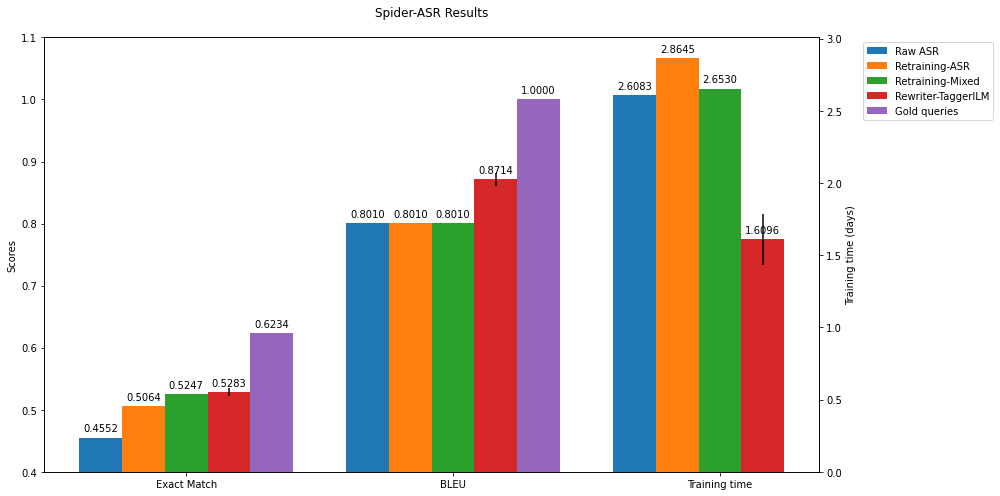

In [163]:
score_types = ['Exact Match', 'BLEU', 'Training time']

method_entries = [
    # [method_name, exact, BLEU, time, exact_err, BLEU_err, time_err]
    ['Raw ASR', 0.4552, 0.8010, 2.6083, None, None, None],
    ['Retraining-ASR', 0.5064, 0.8010, 2.8645, None, None, None],
    ['Retraining-Mixed', 0.5247, 0.8010, 2.6530, None, None, None],
    ['Rewriter-TaggerILM', 0.5283, 0.8714, 1.6096, 0.0065, 0.0103, 0.1760],
    ['Gold queries', 0.6234, 1.0000, None, None, None, None],
]

x = np.arange(len(score_types)) * 5  # the label locations
width = 0.8  # the width of the bars

fig = plt.figure(figsize=(14,7))
ax = fig.gca()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

n = len(method_entries)
rects = []
for i in range(n):
    method_name, exact, BLEU, time, exact_err, BLEU_err, time_err = method_entries[i]
    
    _vals = [exact, BLEU]
    _errs = [exact_err, BLEU_err]
    
#     _y = np.ma.masked_where(condition=[_v is None for _v in _vals], a=_vals).astype(float)
#     _yerr = np.ma.masked_where(condition=[_v is None for _v in _errs], a=_errs).astype(float)

    _y = np.array([_v or np.nan for _v in _vals])
    _yerr = np.array([_v or np.nan for _v in _errs])
    
    _bias = - (width / 2) * (n-1) + width * i
    _rects = ax.bar(x[:2] + _bias , _y,
                    yerr=_yerr,
                    width=width,
                    label=method_name)
    rects.append(_rects)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Spider-ASR Results\n')
ax.set_xticks(x)
ax.set_xticklabels(score_types)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim((0.4, 1.1))
for _rects in rects:
    autolabel(_rects, ax)

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
rects = []
for i in range(n):
    method_name, exact, BLEU, time, exact_err, BLEU_err, time_err = method_entries[i]
    
    _vals = [time]
    _errs = [time_err]
    
#     _y = np.ma.masked_where(condition=[_v is None for _v in _vals], a=_vals).astype(float)
#     _yerr = np.ma.masked_where(condition=[_v is None for _v in _errs], a=_errs).astype(float)

    _y = np.array([_v or np.nan for _v in _vals])
    _yerr = np.array([_v or np.nan for _v in _errs])
    
    _bias = - (width / 2) * (n-1) + width * i
    _rects = ax2.bar(x[2:] + _bias , _y,
                    yerr=_yerr,
                    width=width,
                    label=method_name)
    rects.append(_rects)
    
ax2.set_ylabel('Training time (days)')
for _rects in rects:
    autolabel(_rects, ax2)

fig.tight_layout()



In [263]:
def MethodsCompResultsPlotting(
    method_entries,
    method_groups,
    y_idx,
    yerr_idx,
    title,
    ylabel='Scores',
    ylim=None,
    n_yticks=None,
    figsize=(8,6),
    output_img_path=None,
):

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

    x = np.arange(len(method_entries)) * 0.6
    y = np.array([_m[y_idx] or np.nan for _m in method_entries])
    yerr = np.array([_m[yerr_idx] or np.nan for _m in method_entries])
    labels = [_m[0] for _m in method_entries]
    width = 0.3

    rects = ax.bar(x, y,
                   yerr=yerr,
                   color='orange',
                   edgecolor='black',
                   width=width,
                   error_kw={'capsize': 4, 'capthick': 2})

    assert len(method_groups) <= 4, method_groups
    group_colors = ['#888888', 'red', 'orange', 'blue']
    group_hatches = ['', '/', '\\', '']
    for g, _group in enumerate(method_groups):
        for i in _group:
            rects[i].set_facecolor(group_colors[g])
            rects[i].set_hatch(group_hatches[g])
#     rects[0].set_facecolor()
#     for i in (1, 2):
#         rects[i].set_hatch('x')
#         rects[i].set_facecolor()
#     for i in (3, 4, 5):
#         rects[i].set_hatch('/')
#     for i in (6, 7):
#         rects[i].set_hatch('//')
#     rects[-1].set_facecolor('blue')

    if ylim is not None:
        ax.set_ylim(ylim)
    if n_yticks is not None:
        ax.set_yticks(np.linspace(ylim[0], ylim[1], n_yticks))
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title + '\n')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.grid(True, color='grey', linewidth=1, linestyle='--')
    ax.tick_params(labelsize=12)

    for i, rect in enumerate(rects):
        _has_err = not np.isnan(yerr[i])
        _y_offset = 12 if _has_err else 8

        _height = rect.get_height()
        _anno = f'{_height:.4f}'
        if _has_err:
            _anno += f'\n(±{yerr[i]:.4f})'

        ax.annotate(_anno,
                    xy=(rect.get_x() + rect.get_width() / 2, _height),
                    xytext=(0, _y_offset),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)

    fig.tight_layout()

    if output_img_path is not None:
        fig.savefig(output_img_path, dpi=200)
    
    return fig

In [256]:
# method_entries = [
#     # [method_name, exact, partial, BLEU, exact_err, partial_err, BLEU_err]
#     ['Blackbox', 0.4552, 0.7274, 0.8010, None, None, None],
#     ['Rat-sql-ASR', 0.5064, 0.7643, 0.8010, None, None, None],
#     ['Rat-sql-mixed', 0.5247, 0.7656, 0.8010, None, None, None],
#     ['Reranker', 0.4942, 0.7541, 0.7730, 0.0153, 0.0094, 0.0142],
#     ['Rewriter-S2S', 0.4845, 0.7473, 0.8492, 0.0138, 0.0091, 0.0061],
#     ['Rewriter-TaggerILM', 0.5027, 0.7578, 0.8578, 0.0055, 0.0025, 0.0019],
#     ['Aggreg. (majority vote)', 0.5204, 0.7681, None, 0.0028, 0.0044, None],
#     ['Aggreg. (extra cands.)', 0.5137, 0.7628, 0.7979, 0.0055, 0.0042, 0.0151],
#     ['Gold queries', 0.6234, 0.8316, 1.0000, None, None, None],
# ]

method_entries = [
    # [method_name, exact, BLEU, time, exact_err, BLEU_err, time_err]
    ['Blackbox ASR (RAT-SQL)', 0.4552, 0.8010, None, None, None, None],
    ['Retraining-ASR (RAT-SQL)', 0.5064, 0.8010, 2.8645, None, None, None],
    ['Retraining-Mixed (RAT-SQL)', 0.5247, 0.8010, 2.6530, None, None, None],
    ['Rewriter-TaggerILM (RAT-SQL)', 0.5283, 0.8714, 1.9718, 0.0065, 0.0103, 0.1939],
    ['Gold queries (RAT-SQL)', 0.6234, 1.0000, None, None, None, None],
    ['Blackbox ASR (Picard)', 0.5539, 0.8010, None, None, None, None],
    ['Rewriter-TaggerILM (Picard)', 0.5872, 0.8714, None, 0.0115, 0.0103, None],
    ['Gold queries (Picard)', 0.6929, 1.0000, None, None, None, None],
]

method_groups = [
    (0,5),
    (1,2),
    (3,6),
    (4,7),
]


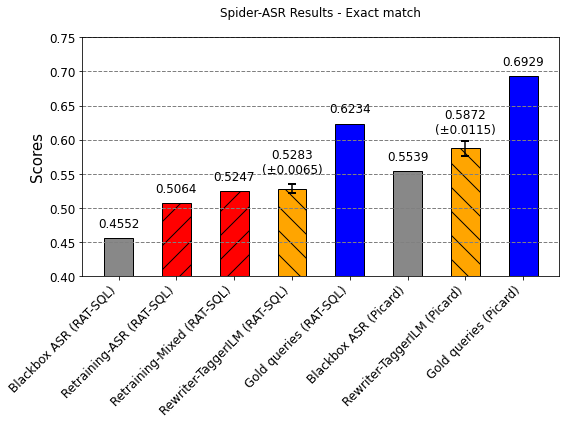

In [257]:
image_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/images/results/2021-11'

os.makedirs(image_dir, exist_ok=True)

fig = MethodsCompResultsPlotting(
    method_entries = method_entries,
    method_groups = method_groups,
    y_idx = 1,
    yerr_idx = 4,
    title = 'Spider-ASR Results - Exact match',
    ylim = (0.4, 0.75),
    n_yticks = None,
    output_img_path = os.path.join(image_dir, 'spider-asr-exact.png'))

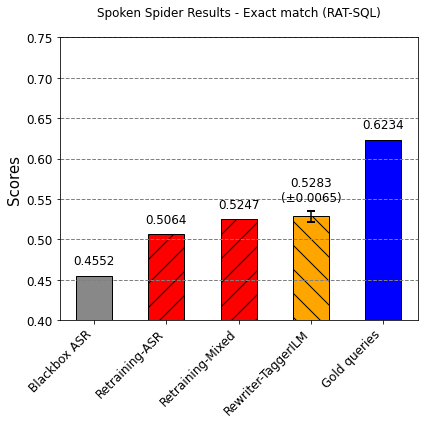

In [312]:
image_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/images/results/2021-11'

_method_entries = [method_entries[i] for i in [0,1,2,3,4]]
_method_names = ['Blackbox ASR', 'Retraining-ASR', 'Retraining-Mixed', 'Rewriter-TaggerILM', 'Gold queries']
for i, name in enumerate(_method_names):
    _method_entries[i][0] = name

_method_groups = [
    (0,),
    (1,2),
    (3,),
    (4,),
]

fig = MethodsCompResultsPlotting(
    method_entries = _method_entries,
    method_groups = _method_groups,
    y_idx = 1,
    yerr_idx = 4,
    title = 'Spoken Spider Results - Exact match (RAT-SQL)',
    ylim = (0.4, 0.75),
    n_yticks = None,
    figsize=(6, 6),
    output_img_path = os.path.join(image_dir, 'spider-asr-exact-ratsql.png'))

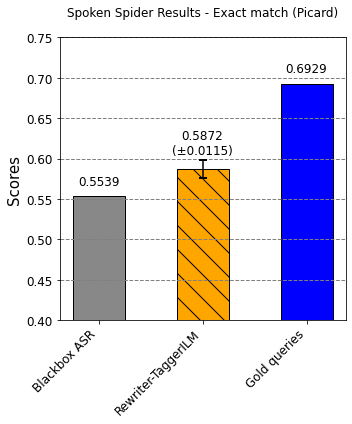

In [314]:
image_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/images/results/2021-11'

_method_entries = [method_entries[i] for i in [5,6,7]]
_method_names = ['Blackbox ASR', 'Rewriter-TaggerILM', 'Gold queries']
for i, name in enumerate(_method_names):
    _method_entries[i][0] = name

_method_groups = [
    (0,),
    tuple(),
    (1,),
    (2,),
]

fig = MethodsCompResultsPlotting(
    method_entries = _method_entries,
    method_groups = _method_groups,
    y_idx = 1,
    yerr_idx = 4,
    title = 'Spoken Spider Results - Exact match (Picard)',
    ylim = (0.4, 0.75),
    n_yticks = None,
    figsize=(5, 6),
    output_img_path = os.path.join(image_dir, 'spider-asr-exact-picard.png'))

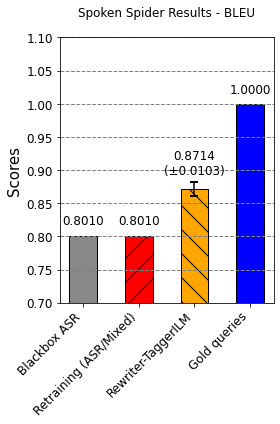

In [315]:
image_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/images/results/2021-11'

_method_entries = [method_entries[i] for i in [0,2,3,4]]
_method_entries[0][0] = 'Blackbox ASR'
_method_entries[1][0] = 'Retraining (ASR/Mixed)'
_method_entries[2][0] = 'Rewriter-TaggerILM'
_method_entries[3][0] = 'Gold queries'

_method_groups = [
    (0,),
    (1,),
    (2,),
    (3,),
]

fig = MethodsCompResultsPlotting(
    method_entries = _method_entries,
    method_groups = _method_groups,
    y_idx = 2,
    yerr_idx = 5,
    title = 'Spoken Spider Results - BLEU',
    ylim = (0.7, 1.1),
    n_yticks = 9,
    figsize = (4, 6),
    output_img_path = os.path.join(image_dir, 'spider-asr-BLEU.png'))

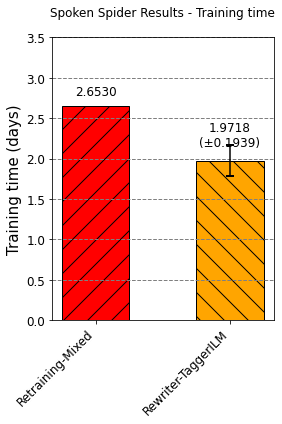

In [316]:
image_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/images/results/2021-11'

_method_entries = [method_entries[i] for i in [2,3]]
_method_entries[0][0] = 'Retraining-Mixed'
_method_entries[1][0] = 'Rewriter-TaggerILM'

_method_groups = [
    tuple(),
    (0,),
    (1,),
    tuple(),
]

fig = MethodsCompResultsPlotting(
    method_entries = _method_entries,
    method_groups = _method_groups,
    y_idx = 3,
    yerr_idx = 6,
    title = 'Spoken Spider Results - Training time',
    ylabel = 'Training time (days)',
    ylim = (0, 3.5),
    n_yticks = None,
    figsize = (4, 6),
    output_img_path = os.path.join(image_dir, 'spider-asr-time.png'))

In [190]:
# # Separate - exact 

# fig = plt.figure(figsize=(10, 5))
# ax = fig.gca()

# x = np.arange(len(method_entries)) * 0.6
# y = np.array([_m[1] or np.nan for _m in method_entries])
# yerr = np.array([_m[4] or np.nan for _m in method_entries])
# labels = [_m[0] for _m in method_entries]
# width = 0.35

# rects = ax.bar(x, y,
#                yerr=yerr,
#                color='orange',
#                width=width,
#                error_kw={'capsize': 4})

# rects[0].set_color('blue')
# for i in (1, 2):
#     rects[i].set_color('red')
# rects[-1].set_color('blue')

# ax.set_ylim(0.4, 0.7)
# ax.set_ylabel('Scores', fontsize=14)
# ax.set_title('Spider-ASR Results - Exact match\n')
# ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation=45, ha='right')
# # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.yaxis.grid(True, color='grey', linewidth=1, linestyle='--')
# ax.tick_params(labelsize=13)

# for i, rect in enumerate(rects):
#     _has_err = not np.isnan(yerr[i])
#     _y_offset = 12 if _has_err else 8
    
#     _height = rect.get_height()
#     _anno = f'{_height:.4f}'
#     if _has_err:
#         _anno += f'\n(±{yerr[i]:.4f})'
    
#     ax.annotate(_anno,
#                 xy=(rect.get_x() + rect.get_width() / 2, _height),
#                 xytext=(0, _y_offset),
#                 textcoords="offset points",
#                 ha='center', va='bottom',
#                 fontsize=12)

# fig.tight_layout()

# fig.savefig('/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/images/results/spider-asr-exact.png',
#             dpi=200)

In [ ]:
# # Separate - partial 

# fig = plt.figure(figsize=(10, 5))
# ax = fig.gca()

# x = np.arange(len(method_entries)) * 0.6
# y = np.array([_m[2] or np.nan for _m in method_entries])
# yerr = np.array([_m[5] or np.nan for _m in method_entries])
# labels = [_m[0] for _m in method_entries]
# width = 0.35

# rects = ax.bar(x, y,
#                yerr=yerr,
#                color='orange',
#                width=width,
#                error_kw={'capsize': 4})

# for i in (1, 2):
#     rects[i].set_color('red')
# rects[-1].set_color('blue')
    
# ax.set_ylim(0.7, 0.85)
# ax.set_yticks(np.linspace(0.7, 0.85, 7))
# ax.set_ylabel('Scores', fontsize=14)
# ax.set_title('Spider-ASR Results - Partial match\n')
# ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation=45, ha='right')
# # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.yaxis.grid(True, color='grey', linewidth=1, linestyle='--')
# ax.tick_params(labelsize=13)

# for i, rect in enumerate(rects):
#     _has_err = not np.isnan(yerr[i])
#     _y_offset = 12 if _has_err else 8
    
#     _height = rect.get_height()
#     _anno = f'{_height:.4f}'
#     if _has_err:
#         _anno += f'\n(±{yerr[i]:.4f})'
    
#     ax.annotate(_anno,
#                 xy=(rect.get_x() + rect.get_width() / 2, _height),
#                 xytext=(0, _y_offset),
#                 textcoords="offset points",
#                 ha='center', va='bottom',
#                 fontsize=12)
    
# fig.tight_layout()

# fig.savefig('/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/images/results/spider-asr-partial.png',
#             dpi=200)

In [ ]:
# # Separate - BLEU 

# fig = plt.figure(figsize=(10, 5))
# ax = fig.gca()

# x = np.arange(len(method_entries)) * 0.6
# y = np.array([_m[3] or np.nan for _m in method_entries])
# yerr = np.array([_m[6] or np.nan for _m in method_entries])
# labels = [_m[0] for _m in method_entries]
# width = 0.35

# rects = ax.bar(x, y,
#                yerr=yerr,
#                color='orange',
#                width=width,
#                error_kw={'capsize': 4})

# for i in (1, 2):
#     rects[i].set_color('red')
# rects[-1].set_color('blue')
    
# ax.set_ylim(0.7, 1.1)
# ax.set_yticks(np.linspace(0.7, 1.1, 9))
# ax.set_ylabel('Scores', fontsize=14)
# ax.set_title('Spider-ASR Results - BLEU\n')
# ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation=45, ha='right')
# # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.yaxis.grid(True, color='grey', linewidth=1, linestyle='--')
# ax.tick_params(labelsize=13)

# for i, rect in enumerate(rects):
#     _has_err = not np.isnan(yerr[i])
#     _y_offset = 12 if _has_err else 8
    
#     _height = rect.get_height()
#     _anno = f'{_height:.4f}'
#     if _has_err:
#         _anno += f'\n(±{yerr[i]:.4f})'
    
#     ax.annotate(_anno,
#                 xy=(rect.get_x() + rect.get_width() / 2, _height),
#                 xytext=(0, _y_offset),
#                 textcoords="offset points",
#                 ha='center', va='bottom',
#                 fontsize=12)
    
# fig.tight_layout()

# fig.savefig('/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/images/results/spider-asr-BLEU.png',
#             dpi=200)

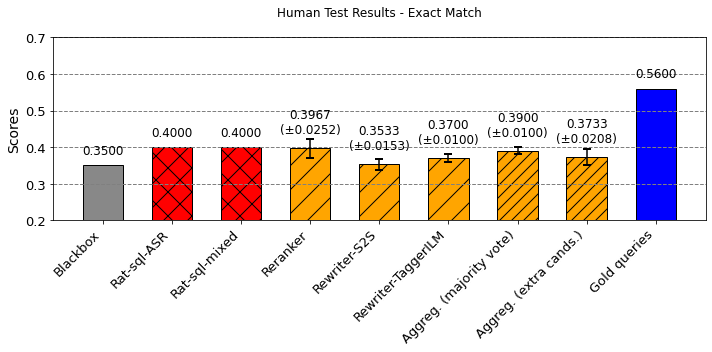

In [458]:
# Human test 
method_entries = [
    # [method_name, exact, partial, BLEU, exact_err, partial_err, BLEU_err]
    ['Blackbox', 0.3500, 0.6779, 0.6934, None, None, None],
    ['Rat-sql-ASR', 0.4000, 0.7103, 0.6934, None, None, None],
    ['Rat-sql-mixed', 0.4000, 0.7119, 0.6934, None, None, None],
    ['Reranker', 0.3967, 0.7184, 0.6720, 0.0252, 0.0106, 0.0219],
    ['Rewriter-S2S', 0.3533, 0.6775, 0.6909, 0.0153, 0.0069, 0.0218],
    ['Rewriter-TaggerILM', 0.3700, 0.6940, 0.7183, 0.0100, 0.0164, 0.0031],
    ['Aggreg. (majority vote)', 0.3900, 0.6994, None, 0.0100, 0.0033, None],
    ['Aggreg. (extra cands.)', 0.3733, 0.7031, 0.6971, 0.0208, 0.0251, 0.0211],
    ['Gold queries', 0.5600, 0.8112, 1.0000, None, None, None],
]

image_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/images/results'

fig = MethodsCompResultsPlotting(
    method_entries,
    y_idx = 1,
    yerr_idx = 4,
    title = 'Human Test Results - Exact Match',
    ylim = (0.2, 0.7),
    n_yticks = None,
    output_img_path = os.path.join(image_dir, 'human-test-exact.png'))



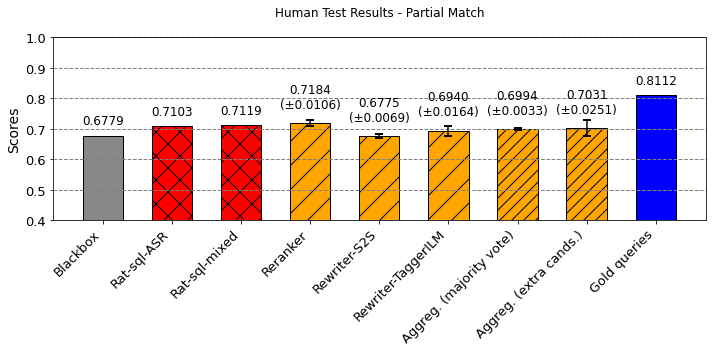

In [459]:
fig = MethodsCompResultsPlotting(
    method_entries,
    y_idx = 2,
    yerr_idx = 5,
    title = 'Human Test Results - Partial Match',
    ylim = (0.4, 1),
    n_yticks = None,
    output_img_path = os.path.join(image_dir, 'human-test-partial.png'))

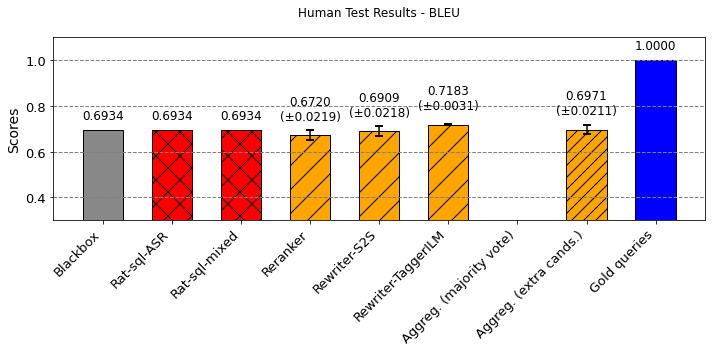

In [460]:
fig = MethodsCompResultsPlotting(
    method_entries,
    y_idx = 3,
    yerr_idx = 6,
    title = 'Human Test Results - BLEU',
    ylim = (0.3, 1.1),
    n_yticks = None,
    output_img_path = os.path.join(image_dir, 'human-test-bleu.png'))

### Gold tagger pred (not used)

In [3]:
base_tag_path = f'/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs/output-2.12.1.0t.json'

with open(base_tag_path, 'r') as f:
    base_preds = [json.loads(l) for l in f]

len(base_preds)

3075

In [ ]:
golds = []

for d in base_preds:
    d['tags_prediction'] = [t for t in d['gold_tags'] if t != 'O']
    d['2.12.1.0t_NLL'] = d['tags_NLL']
    d['2.12.1.0t_accuracy'] = d['tags_accuracy']
    d['tags_NLL'] = 0.0
    d['tags_accuracy'] = 1.0
    golds.append(d)

golds[200]

In [7]:
gold_tag_path = f'/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs/output-gold-t.json'

with open(gold_tag_path, 'w') as f:
    for d in golds:
        f.write(json.dumps(d) + '\n')


### SQL Execution results

In [ ]:
# world_1
# ASR Question: what are the names of the countries that are in the continent of Europe and have a population of 80,000?
# Rwt Question: what are the names of the countries that are in the continent of Europe and have a population of 50000?
# Compare SQL: select name from country where continent = 'Europe' and population = 80,000 (0)
# Rwt Question SQL: select name from country where continent = 'Europe' and population = 50000 (1)
# Gold Question: What are the names of the countries that are in the continent of Europe and have a population of 80000?
# Gold SQL: SELECT Name FROM country WHERE continent  =  "Europe" AND Population  =  "80000"

In [186]:
import sqlite3

db_id = 'world_1'
db_path = f'/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database/{db_id}/world_1.sqlite'

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

sql_query = "select name, population from country where continent = 'Europe'"
# sql_query = "select name from country where continent = 'Europe' and population = 80,000"

cursor.execute(sql_query)
p_res = cursor.fetchall()

In [187]:
p_res

[('Albania', 3401200),
 ('Andorra', 78000),
 ('Austria', 8091800),
 ('Belgium', 10239000),
 ('Bulgaria', 8190900),
 ('Bosnia and Herzegovina', 3972000),
 ('Belarus', 10236000),
 ('Switzerland', 7160400),
 ('Czech Republic', 10278100),
 ('Germany', 82164700),
 ('Denmark', 5330000),
 ('Spain', 39441700),
 ('Estonia', 1439200),
 ('Finland', 5171300),
 ('France', 59225700),
 ('Faroe Islands', 43000),
 ('United Kingdom', 59623400),
 ('Gibraltar', 25000),
 ('Greece', 10545700),
 ('Croatia', 4473000),
 ('Hungary', 10043200),
 ('Ireland', 3775100),
 ('Iceland', 279000),
 ('Italy', 57680000),
 ('Liechtenstein', 32300),
 ('Lithuania', 3698500),
 ('Luxembourg', 435700),
 ('Latvia', 2424200),
 ('Monaco', 34000),
 ('Moldova', 4380000),
 ('Macedonia', 2024000),
 ('Malta', 380200),
 ('Netherlands', 15864000),
 ('Norway', 4478500),
 ('Poland', 38653600),
 ('Portugal', 9997600),
 ('Romania', 22455500),
 ('Russian Federation', 146934000),
 ('Svalbard and Jan Mayen', 3200),
 ('San Marino', 27000),
 ('Slo

### Temp

In [204]:
_vals = [1,2,None]

np.ma.masked_where(condition=[_val is None for _val in _vals],
                            a=_vals).astype(float)

masked_array(data=[1.0, 2.0, --],
             mask=[False, False,  True],
       fill_value=1e+20)

In [50]:
d1 = {'a': 1, 'b': 2, 'c': {'a': 1, 'b': 2}}
d2 = {'b': 2, 'a': 1, 'c': {'b': 2, 'a': 1}}

In [51]:
d1, d2

({'a': 1, 'b': 2, 'c': {'a': 1, 'b': 2}},
 {'b': 2, 'a': 1, 'c': {'b': 2, 'a': 1}})

In [52]:
d1 is d1, d1 is d2, d1 == d2

(True, False, True)

In [53]:
pickle.dumps(d1),pickle.dumps(d2)

(b'\x80\x03}q\x00(X\x01\x00\x00\x00aq\x01K\x01X\x01\x00\x00\x00bq\x02K\x02X\x01\x00\x00\x00cq\x03}q\x04(h\x01K\x01h\x02K\x02uu.',
 b'\x80\x03}q\x00(X\x01\x00\x00\x00bq\x01K\x02X\x01\x00\x00\x00aq\x02K\x01X\x01\x00\x00\x00cq\x03}q\x04(h\x01K\x02h\x02K\x01uu.')

In [54]:
json.dumps(d1, sort_keys=True), json.dumps(d2, sort_keys=True)

('{"a": 1, "b": 2, "c": {"a": 1, "b": 2}}',
 '{"a": 1, "b": 2, "c": {"a": 1, "b": 2}}')

In [59]:
Counter([1,1,2]).most_common(1)

[(1, 2)]

In [373]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [374]:
%memit

peak memory: 694.88 MiB, increment: 0.16 MiB


In [8]:
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits, \
    get_device_of, masked_softmax, masked_log_softmax, weighted_sum, \
    get_mask_from_sequence_lengths, get_lengths_from_binary_sequence_mask, tensors_equal

concat_lens = [6,4,7,6]
text_lens = [2,1,6,3]

concat_mask = get_mask_from_sequence_lengths(torch.LongTensor(concat_lens), max_length=10)
text_mask = get_mask_from_sequence_lengths(torch.LongTensor(text_lens), max_length=10)


In [9]:
concat_mask

tensor([[ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False]])

In [10]:
text_mask

tensor([[ True,  True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False]])

In [17]:
schema_mask = torch.logical_xor(concat_mask, text_mask)
schema_mask

tensor([[False, False,  True,  True,  True,  True, False, False, False, False],
        [False,  True,  True,  True, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True, False, False, False],
        [False, False, False,  True,  True,  True, False, False, False, False]])

In [42]:
a = torch.FloatTensor(range(400)).view((4,10,10))
a

tensor([[[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
         [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.],
         [ 20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.],
         [ 30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.],
         [ 40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.],
         [ 50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.],
         [ 60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.],
         [ 70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.],
         [ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.],
         [ 90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.]],

        [[100., 101., 102., 103., 104., 105., 106., 107., 108., 109.],
         [110., 111., 112., 113., 114., 115., 116., 117., 118., 119.],
         [120., 121., 122., 123., 124., 125., 126., 127., 128., 129.],
         [130., 131., 132., 133., 134., 135., 136., 137., 138., 139.],
    

In [44]:
m1 = torch.nn.Linear(10, 1)
m2 = torch.nn.Linear(10, 1)

a2 = m1(a) * text_mask.unsqueeze(-1) - m2(a) * schema_mask.unsqueeze(-1)
a2

tensor([[[  -3.1339],
         [  -9.6698],
         [  -2.9938],
         [  -3.9154],
         [  -4.8370],
         [  -5.7587],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000]],

        [[ -68.4931],
         [ -11.2884],
         [ -12.2100],
         [ -13.1316],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000]],

        [[-133.8523],
         [-140.3882],
         [-146.9241],
         [-153.4601],
         [-159.9960],
         [-166.5319],
         [ -25.1126],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000]],

        [[-199.2115],
         [-205.7474],
         [-212.2833],
         [ -31.5639],
         [ -32.4855],
         [ -33.4071],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000],
         [  -0.0000]]], grad_fn=<SubBackward0>)

In [45]:
a2.sum().backward()

In [47]:
m1.weight.grad, '\n', m1.bias.grad

(tensor([[2390., 2402., 2414., 2426., 2438., 2450., 2462., 2474., 2486., 2498.]]),
 '\n',
 tensor([12.]))

In [48]:
m2.weight.grad, '\n', m2.bias.grad

(tensor([[-1780., -1791., -1802., -1813., -1824., -1835., -1846., -1857., -1868.,
          -1879.]]),
 '\n',
 tensor([-11.]))

In [50]:
nlp = spacy.load("en_core_web_sm")
nlp

In [64]:
d = nlp('reduction reduce reducing reduced reduces')
[t.lemma_ for t in d]

['reduction', 'reduce', 'reduce', 'reduced', 'reduce']

In [62]:
doc = nlp("I've made a \"asdfe fgh\" yesterday.")
list(doc)

[I, 've, made, a, ", asdfe, fgh, ", yesterday, .]

In [71]:
_path1 = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs/DEBUG-cpu-TEMP-output-2.31.0.0i-oracle-tags.json'
_path2 = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs/DEBUG-cpu-TEMP2-output-2.31.0.0i-oracle-tags.json'

with open(_path1, 'r') as f:
    _outs1 = [json.loads(l) for l in f]
with open(_path2, 'r') as f:
    _outs2 = [json.loads(l) for l in f]

len(_outs1), len(_outs2)

(39, 39)

In [72]:
for i, (o1, o2) in enumerate(zip(_outs1, _outs2)):
    if o1['rewrite_seq_prediction'] != o2['rewrite_seq_prediction']:
        print(i)

8
15
20
